In [290]:
import math
import random
import os
import json
import statistics

import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import seaborn as sns
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.svm import LinearSVR

from scipy import stats
from scipy.stats import norm

from factor_analyzer import FactorAnalyzer, Rotator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from pathlib import Path 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import stats
from scipy.stats import norm
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import roc_curve, auc

In [3]:
import warnings
warnings.filterwarnings("ignore")

Data is taken from: https://www.kaggle.com/competitions/ga-customer-revenue-prediction/data?select=train.csv . Data is from Google Merchandise Store and shows purchases.

### Research questions:

- What are the key factors that significantly influence the chance to perform a purchase?
- What is the influence of visit parameters on the amount spent on purchases?
- What are the groups of visits in the GMS that need special attention?

Such information could be helpful in adapting the website interface more to such circumstances under which most purchases are performed since they provide more cash.

# Data preprocessing:

- Some columns are groupped -> need to be normalized
- Data is rather big (>1.5 Gigabyte); thus, we take only 10% of the data (~90365 items)

In [4]:
group_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
# fullvisitorId - должно быть только string, так как при чтении в float может округлиться
df = pd.read_csv('train.csv', 
                     converters={col: json.loads for col in group_columns}, 
                     dtype={'fullVisitorId': 'str'}, low_memory=False)
# Берем случайные 10% выборки
df = df.sample(frac=0.1).reset_index(drop=True)
    
for col in group_columns:
    # Нормализация каждого сгруппированного столбца
    normalizedColumn = pd.json_normalize(df[col])
    # Именование каждого столбца
    normalizedColumn.columns = [f"{col}.{parameter}" for parameter in normalizedColumn.columns]
    # Удаление сгрупиированного столбца и добавление новых столбцов к DF
    df = df.drop(col, axis=1)
    df = df.merge(normalizedColumn, right_index=True, left_index=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90365 entries, 0 to 90364
Data columns (total 54 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   channelGrouping                                    90365 non-null  object
 1   date                                               90365 non-null  int64 
 2   fullVisitorId                                      90365 non-null  object
 3   sessionId                                          90365 non-null  object
 4   socialEngagementType                               90365 non-null  object
 5   visitId                                            90365 non-null  int64 
 6   visitNumber                                        90365 non-null  int64 
 7   visitStartTime                                     90365 non-null  int64 
 8   device.browser                                     90365 non-null  object
 9   device.browserVer

In [6]:
# Fixing type
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].astype(float)

Removing columns with either unavailable data or data that is described by other columns:

In [7]:
df = df.drop(['sessionId', 
              'visitId', 
              'visitStartTime', 
              'device.browserVersion', 
              'device.browserSize', 
              'device.operatingSystemVersion', 
              'device.mobileDeviceBranding', 
              'device.mobileDeviceModel',
              'device.mobileInputSelector',
              'device.mobileDeviceInfo',
              'device.mobileDeviceMarketingName',
              'device.flashVersion',
              'device.screenColors',
              'device.screenResolution',
              'geoNetwork.country', 
              'geoNetwork.region', 
              'geoNetwork.metro', 
              'geoNetwork.city', 
              'geoNetwork.cityId', 
              'geoNetwork.latitude', 
              'geoNetwork.longitude', 
              'geoNetwork.networkLocation', 
              'totals.visits', 
              'trafficSource.referralPath', 
              'trafficSource.adwordsClickInfo.criteriaParameters', 
              'geoNetwork.subContinent', 
              'geoNetwork.networkDomain', 
              'trafficSource.campaign', 
              'trafficSource.medium', 
              'trafficSource.keyword', 
              'trafficSource.isTrueDirect', 
              'trafficSource.adwordsClickInfo.page', 
              'trafficSource.adwordsClickInfo.slot', 
              'trafficSource.adwordsClickInfo.gclId', 
              'trafficSource.adwordsClickInfo.isVideoAd', 
              'trafficSource.adContent', 'device.isMobile', 
              'trafficSource.source', 
              'socialEngagementType',
              'fullVisitorId',
              'device.language',
              'totals.newVisits'], 1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90365 entries, 0 to 90364
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   channelGrouping                               90365 non-null  object 
 1   date                                          90365 non-null  int64  
 2   visitNumber                                   90365 non-null  int64  
 3   device.browser                                90365 non-null  object 
 4   device.operatingSystem                        90365 non-null  object 
 5   device.deviceCategory                         90365 non-null  object 
 6   geoNetwork.continent                          90365 non-null  object 
 7   totals.hits                                   90365 non-null  object 
 8   totals.pageviews                              90358 non-null  object 
 9   totals.bounces                                45071 non-null 

Transforming date to datetime:

In [9]:
from datetime import datetime, timedelta
for i in range(len(df['date'])):
    dateString = str(df.loc[i, 'date'])
    df.loc[i, 'date'] = datetime(year=int(dateString[0:4]), month=int(dateString[4:6]), day=int(dateString[6:8]))
df['date'] = pd.to_datetime(df['date'])

df["weekday"] = df["date"].dt.day_name()
df['weekday'] = df['weekday'].astype('category')

Total hits is transformed into integer type:

In [10]:
df['totals.hits'] = df['totals.hits'].astype(int)

We presume that if totals.pageviews is empty then only 1 page is viewed, since it cannot be zero here:

In [11]:
df['totals.pageviews'] = df['totals.pageviews'].fillna(1)
df['totals.pageviews'] = df['totals.pageviews'].astype(int)

Empty total.bounces means that there were no bounces; thus, we fill nulls with false:

In [12]:
df['totals.bounces'] = df['totals.bounces'].fillna(0)
df['totals.bounces'] = df['totals.bounces'].astype(bool)

Here only 'Google Search' exists in data (no other options). The column means that the adds were clicked by a user. Thus, if it is null, adds were not clicked, therefore we can fill it with false:

In [13]:
df['trafficSource.adwordsClickInfo.adNetworkType'] = df['trafficSource.adwordsClickInfo.adNetworkType'].fillna(0)
df['trafficSource.adwordsClickInfo.adNetworkType'] = df['trafficSource.adwordsClickInfo.adNetworkType'].astype(bool)

In [14]:
df['channelGrouping'] = df['channelGrouping'].astype('category')

We cut off browsers that are not really representative in the dataset:

In [15]:
popular_browsers = df["device.browser"].value_counts()[:6]
for i in range(0, len(df["device.browser"])):
    if not df["device.browser"][i] in popular_browsers:
        df["device.browser"][i] = "Other"
df["device.browser"] = df["device.browser"].astype('category')
df["device.browser"].value_counts()

Chrome               61831
Safari               18427
Firefox               3745
Other                 2634
Internet Explorer     1912
Edge                  1019
Android Webview        797
Name: device.browser, dtype: int64

We cut off operating systems that are not really representative in the dataset:

In [16]:
operating_systems = df["device.operatingSystem"].value_counts()[:6]
for i in range(0, len(df["device.operatingSystem"])):
    if not df["device.operatingSystem"][i] in operating_systems:
        df["device.operatingSystem"][i] = "Other"
df["device.operatingSystem"] = df["device.operatingSystem"].astype('category')
df["device.operatingSystem"].value_counts()

Windows      35044
Macintosh    25173
Android      12470
iOS          10975
Linux         3423
Chrome OS     2634
Other          646
Name: device.operatingSystem, dtype: int64

In [17]:
df["device.deviceCategory"] = df["device.deviceCategory"].astype('category')

In [18]:
df["geoNetwork.continent"] = df["geoNetwork.continent"].astype('category')

If totals.transactionRevenue is null, no revenue is obtained; thus, nan is replaces with 0

In [19]:
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].fillna(0)
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].astype(float)
#df['totals.transactionRevenue'] = df['totals.transactionRevenue'].apply(lambda x: (x - np.min(df['totals.transactionRevenue'])) / (np.max(df['totals.transactionRevenue']) - np.min(df['totals.transactionRevenue'])))

Since weekend is saved, date can be removed:

In [20]:
df = df.drop('date', 1)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90365 entries, 0 to 90364
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   channelGrouping                               90365 non-null  category
 1   visitNumber                                   90365 non-null  int64   
 2   device.browser                                90365 non-null  category
 3   device.operatingSystem                        90365 non-null  category
 4   device.deviceCategory                         90365 non-null  category
 5   geoNetwork.continent                          90365 non-null  category
 6   totals.hits                                   90365 non-null  int32   
 7   totals.pageviews                              90365 non-null  int32   
 8   totals.bounces                                90365 non-null  bool    
 9   totals.transactionRevenue                     9036

In [22]:
df.to_csv(r'AfterPreprocessing.csv')

## Result Dataset Description:

Dataset contains 90365 entries. Each row describes a visit into a GMS (Google Merchandise Store).

Columns description:
- channelGrouping - how the redirect to GMS website is performed (social networks, browser search, direct link, referral, etc.)
- visitNumber -  the session number for the user. If this is the first session, then this is set to 1.
- device.browser - browser used to access the website.
- device.operatingSystem - OS used to access the website.
- device.deviceCategory - type of device (PC, phone, tablet).
- geoNetwork.continent - continent from which the request is performed.
- totals.hits - number of website hits during the session.
- totals.pageviews - number of pages viewed during the session.
- totals.bounces - payment is cancelled (true - if cancelled, false - if not).
- totals.transactionRevenue - amount of money spent by the user during the session.
- trafficSource.adwordsClickInfo.adNetworkType - was the click on advertisements performed (true if yes)
- weekday - weekday of the session

# Descriptive Analysis

First, all the variables are described on their own and further they are compared with a chance to perform a purchase

### Categorical variable description

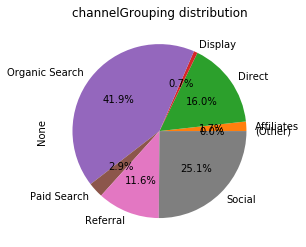

In [23]:
df.groupby('channelGrouping').size().plot(kind='pie', title = 'channelGrouping distribution',autopct='%1.1f%%')

It is seen that most of the visits are done through the organic search (42%), social networks (25%) and direct links (16%).

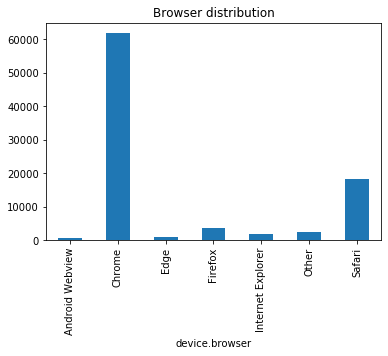

In [24]:
df.groupby('device.browser').size().plot(kind='bar', title = 'Browser distribution')

In [25]:
df['device.browser'].value_counts()

Chrome               61831
Safari               18427
Firefox               3745
Other                 2634
Internet Explorer     1912
Edge                  1019
Android Webview        797
Name: device.browser, dtype: int64

In most cases, Chrome is used as a browser (>70%), the next browser is Safari (>20%) and all other browsers are significantly rarely used (less than 5% each).

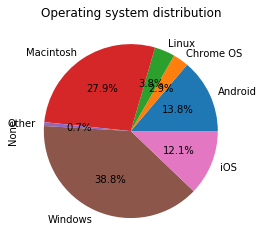

In [26]:
df.groupby('device.operatingSystem').size().plot(kind='pie', title = 'Operating system distribution',autopct='%1.1f%%')

Most visits are done through the Windows (>38%). A relatively high amount of visits is also done through Macintosh (28%). Android and iOS are nearly the same. All other OS are used in less than 6% cases.

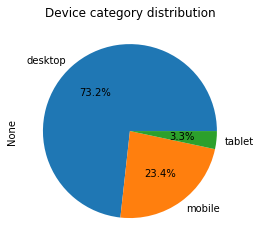

In [27]:
df.groupby('device.deviceCategory').size().plot(kind='pie', title = 'Device category distribution',autopct='%1.1f%%')

Most visits are done through desktop (73%) and only 23% are done through mobiles. Tablet is not sufficiently represented in the dataset (only 3.3%).

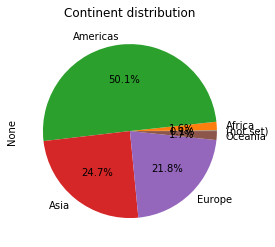

In [28]:
df.groupby('geoNetwork.continent').size().plot(kind='pie', title = 'Continent distribution',autopct='%1.1f%%')

Half of visits are from Americas, 25% and 22% are done through Asia and Europe,respectively. It is seen that visits from Africa and Oceania are not quite represented in the dataset.

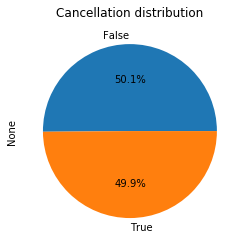

In [29]:
df.groupby('totals.bounces').size().plot(kind='pie', title = 'Cancellation distribution',autopct='%1.1f%%')

Cancellation is equally distributed among True and False, so equal number of visits faced bounces and not faced bounces

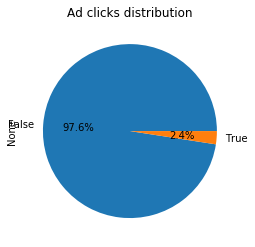

In [30]:
df.groupby('trafficSource.adwordsClickInfo.adNetworkType').size().plot(kind='pie', title = 'Ad clicks distribution',autopct='%1.1f%%')

We see that more than 97% of visits avoid advertisements, so such variable is not sufficiently representative on this dataset.

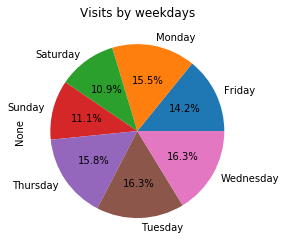

In [31]:
df.groupby('weekday').size().plot(kind='pie', title = 'Visits by weekdays',autopct='%1.1f%%')

It is seen that significantly less visits are done in weekends (avg 15% in working days in comparison to 11% in weekends). The most popular day to visit is Tuesday.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90365 entries, 0 to 90364
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   channelGrouping                               90365 non-null  category
 1   visitNumber                                   90365 non-null  int64   
 2   device.browser                                90365 non-null  category
 3   device.operatingSystem                        90365 non-null  category
 4   device.deviceCategory                         90365 non-null  category
 5   geoNetwork.continent                          90365 non-null  category
 6   totals.hits                                   90365 non-null  int32   
 7   totals.pageviews                              90365 non-null  int32   
 8   totals.bounces                                90365 non-null  bool    
 9   totals.transactionRevenue                     9036

In [33]:
pd.crosstab(df['channelGrouping'], df['device.browser'])

device.browser,Android Webview,Chrome,Edge,Firefox,Internet Explorer,Other,Safari
channelGrouping,,,,,,,
(Other),0,15,0,0,0,0,1
Affiliates,46,1250,27,99,43,14,102
Direct,255,10267,143,503,502,723,2105
Display,1,519,3,30,3,4,73
Organic Search,114,26093,384,1960,650,588,8102
Paid Search,6,1792,30,56,24,11,663
Referral,53,9741,35,219,44,65,304
Social,322,12154,397,878,646,1229,7077


Channels are distributed almost equally among the browsers used. Chrome is most popular among all groupings. The only interesting point is that, in comparison to Chrome and Firefox, a far more portion of visits are done through social networks: for Android Webview, Edge, IE, Other this channel is the leading one.

In [34]:
pd.crosstab(df['channelGrouping'], df['device.operatingSystem'])

device.operatingSystem,Android,Chrome OS,Linux,Macintosh,Other,Windows,iOS
channelGrouping,,,,,,,
(Other),3,0,1,6,0,2,4
Affiliates,108,13,39,364,1,1017,39
Direct,3227,486,875,3426,214,4067,2203
Display,99,44,64,236,1,120,69
Organic Search,6310,1237,812,7813,132,14476,7111
Paid Search,658,99,9,526,0,658,632
Referral,376,657,1268,5549,6,2397,208
Social,1689,98,355,7253,292,12307,709


Distribution of channels is almost equal among the operation systems. However, in iOS and Chrome OS redirect through social channels is far less popular in comparison to other OS. In addition, Referral channels are particularly popular in Linux (the most popular channel), but the reason for this situation is currently unknown.

In [35]:
pd.crosstab(df['channelGrouping'], df['device.deviceCategory'])

device.deviceCategory,desktop,mobile,tablet
channelGrouping,,,
(Other),8,7,1
Affiliates,1428,138,15
Direct,8859,5052,587
Display,465,157,11
Organic Search,24279,11867,1745
Paid Search,1286,1099,197
Referral,9870,535,56
Social,19997,2307,399


Affiliates, Referrals and Social are much more often in desktop visits and are far less often in tablet and mobile visits. As for other channels, the are almost equally distributed among the operation systems.

In [36]:
pd.crosstab(df['channelGrouping'], df['geoNetwork.continent'])

geoNetwork.continent,(not set),Africa,Americas,Asia,Europe,Oceania
channelGrouping,,,,,,
(Other),0,0,16,0,0,0
Affiliates,3,17,543,496,484,38
Direct,25,215,8940,2504,2658,156
Display,0,0,628,2,3,0
Organic Search,42,328,18794,7163,10553,1011
Paid Search,1,13,2353,148,62,5
Referral,4,29,7909,1220,1212,87
Social,40,839,6108,10794,4724,198


In Asia, Social channels are significantly more popular than in other continents. Referral redirects and Paid Searches occur far often in Americas and far less in other continents. Display channel is mostly used in America and there are only few usages in other countries. All other channels are distributed nearly equally among the continents.

In [37]:
pd.crosstab(df['channelGrouping'], df['totals.bounces'])

totals.bounces,False,True
channelGrouping,,
(Other),9,7
Affiliates,743,838
Direct,7227,7271
Display,409,224
Organic Search,19739,18152
Paid Search,1601,981
Referral,7739,2722
Social,7827,14876


Affiliates, Direct, Organic Search are quite equally distributed among the bounces. There is a greater chance for cancellation if a channel is Social and a far less chance if a channel is Display, Paid Search or Referral.

In [38]:
pd.crosstab(df['channelGrouping'], df['trafficSource.adwordsClickInfo.adNetworkType'])

trafficSource.adwordsClickInfo.adNetworkType,False,True
channelGrouping,,
(Other),16,0
Affiliates,1581,0
Direct,14498,0
Display,633,0
Organic Search,37891,0
Paid Search,379,2203
Referral,10461,0
Social,22703,0


The adds are clicked only through the paid search. The variable is not quite representative, however, in some paid searches ads are not clicked.

In [39]:
pd.crosstab(df['channelGrouping'], df['weekday'])

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
channelGrouping,,,,,,,
(Other),2,2,1,1,6,3,1
Affiliates,204,280,107,133,295,277,285
Direct,2068,2334,1397,1331,2261,2550,2557
Display,99,112,42,54,106,118,102
Organic Search,5341,5669,4317,4391,5979,6073,6121
Paid Search,363,330,343,355,417,391,383
Referral,1584,1910,623,737,1880,1922,1805
Social,3132,3369,2980,2999,3350,3423,3450


Channels are equally distributed among week days

In [40]:
pd.crosstab(df['device.browser'], df['device.operatingSystem'])

device.operatingSystem,Android,Chrome OS,Linux,Macintosh,Other,Windows,iOS
device.browser,,,,,,,
Android Webview,797,0,0,0,0,0,0
Chrome,11036,2634,3056,15365,18,28495,1227
Edge,0,0,0,0,6,1013,0
Firefox,118,0,200,555,10,2862,0
Internet Explorer,0,0,0,0,19,1893,0
Other,519,0,101,32,513,779,690
Safari,0,0,66,9221,80,2,9058


The correlations here are very obvious since some browsers are linked with operation systems. Thus, Android Webview is used only in Androids, Edge is only in Windows and some other OS, the same for IE, while Safari is mainly used in Macintosh and iOS. Thus, these variables can very roughly describe each other.

In [41]:
pd.crosstab(df['device.browser'], df['device.deviceCategory'])

device.deviceCategory,desktop,mobile,tablet
device.browser,,,
Android Webview,0,734,63
Chrome,49562,11274,995
Edge,990,27,2
Firefox,3617,128,0
Internet Explorer,1766,105,41
Other,968,1494,172
Safari,9289,7400,1738


Android Webview is mainly used on mobiles in contrast to other browsers (despite 'Other' section). All other browsers are represented nearly equally among device categoies. However, it is seen that Safari is particularly popular on mobiles (almost equally as on desktops) and it outperforms all the other browsers on tablets.

In [42]:
pd.crosstab(df['device.browser'], df['geoNetwork.continent'])

geoNetwork.continent,(not set),Africa,Americas,Asia,Europe,Oceania
device.browser,,,,,,
Android Webview,1,43,228,363,153,9
Chrome,66,757,33427,14003,12603,975
Edge,0,8,463,178,350,20
Firefox,4,101,1229,843,1510,58
Internet Explorer,11,12,767,439,627,56
Other,26,257,687,903,725,36
Safari,7,263,8490,5598,3728,341


Browsers are quite equally distributed among the continents.

In [43]:
pd.crosstab(df['device.browser'], df['totals.bounces'])

totals.bounces,False,True
device.browser,,
Android Webview,345,452
Chrome,32875,28956
Edge,445,574
Firefox,1482,2263
Internet Explorer,756,1156
Other,924,1710
Safari,8467,9960


On average, distribution is quite equal. However, with the use of Firefox, IE and Other browsers the chance for cancellation is significantly higher. The lowest chance for cancellation is for Chrome.

In [44]:
pd.crosstab(df['device.browser'], df['trafficSource.adwordsClickInfo.adNetworkType'])

trafficSource.adwordsClickInfo.adNetworkType,False,True
device.browser,,
Android Webview,795,2
Chrome,60279,1552
Edge,992,27
Firefox,3698,47
Internet Explorer,1893,19
Other,2630,4
Safari,17875,552


Browsers are equally distributed among the possiblity to click on ads.

In [45]:
pd.crosstab(df['device.browser'], df['weekday'])

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
device.browser,,,,,,,
Android Webview,106,118,113,117,98,127,118
Chrome,8746,9812,6103,6286,10157,10387,10340
Edge,134,166,134,135,143,162,145
Firefox,542,555,401,422,615,593,617
Internet Explorer,273,334,184,200,271,321,329
Other,375,343,375,371,371,430,369
Safari,2617,2678,2500,2470,2639,2737,2786


Browsers are equally distributed among the weekdays.

In [46]:
pd.crosstab(df['device.operatingSystem'], df['device.deviceCategory'])

device.deviceCategory,desktop,mobile,tablet
device.operatingSystem,,,
Android,10,11591,869
Chrome OS,2634,0,0
Linux,3411,11,1
Macintosh,25169,4,0
Other,78,568,0
Windows,34888,113,43
iOS,2,8875,2098


Here all the relationships can be explained by close relations of OS and type of devices.

In [47]:
pd.crosstab(df['device.operatingSystem'], df['geoNetwork.continent'])

geoNetwork.continent,(not set),Africa,Americas,Asia,Europe,Oceania
device.operatingSystem,,,,,,
Android,16,281,6024,3187,2746,216
Chrome OS,0,5,2098,167,329,35
Linux,2,32,2546,413,413,17
Macintosh,5,272,14293,6078,4164,361
Other,22,188,65,269,98,4
Windows,62,622,13314,10900,9574,572
iOS,8,41,6951,1313,2372,290


Operating systems are nearly equally distributed among countries, but it is worth mentioning that, in contrast to other continents, in Americas top-1 OS is not Windows but Macintosh.

In [48]:
pd.crosstab(df['device.operatingSystem'], df['totals.bounces'])

totals.bounces,False,True
device.operatingSystem,,
Android,5838,6632
Chrome OS,1688,946
Linux,2081,1342
Macintosh,14411,10762
Other,227,419
Windows,15489,19555
iOS,5560,5415


There is a greater chance that a cancellation is done on Windows and Android, and a lower chance that a cancellation is done on Chrome OS, Linux, Mac and iOS.

In [49]:
pd.crosstab(df['device.operatingSystem'], df['trafficSource.adwordsClickInfo.adNetworkType'])

trafficSource.adwordsClickInfo.adNetworkType,False,True
device.operatingSystem,,
Android,11929,541
Chrome OS,2538,96
Linux,3417,6
Macintosh,24688,485
Other,646,0
Windows,34495,549
iOS,10449,526


OSs are roughly equally distributed among the possiblity to click on ads.

In [50]:
pd.crosstab(df['device.operatingSystem'], df['weekday'])

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
device.operatingSystem,,,,,,,
Android,1757,1733,1726,1661,1876,1808,1909
Chrome OS,399,438,186,199,470,462,480
Linux,613,595,181,207,585,602,640
Macintosh,3512,4215,2270,2389,4124,4400,4263
Other,89,93,80,90,107,96,91
Windows,4857,5433,3782,3892,5629,5767,5684
iOS,1566,1499,1585,1563,1503,1622,1637


Visits from Androids and iOS are equally distributed among the weekdays, while visits from other operating systems are significantly less in weekends than in working days.

In [51]:
pd.crosstab(df['device.deviceCategory'], df['geoNetwork.continent'])

geoNetwork.continent,(not set),Africa,Americas,Asia,Europe,Oceania
device.deviceCategory,,,,,,
desktop,77,928,32218,17530,14457,982
mobile,35,489,11481,4419,4339,399
tablet,3,24,1592,378,900,114


Visits from mobiles are more often in Americas, Africa and Oceania, in contrast to mobile visits from other continents

In [52]:
pd.crosstab(df['device.deviceCategory'], df['totals.bounces'])

totals.bounces,False,True
device.deviceCategory,,
desktop,33608,32584
mobile,10162,11000
tablet,1524,1487


Bounces are nearly equally distributed among device categories

In [53]:
pd.crosstab(df['device.deviceCategory'], df['trafficSource.adwordsClickInfo.adNetworkType'])

trafficSource.adwordsClickInfo.adNetworkType,False,True
device.deviceCategory,,
desktop,65061,1131
mobile,20259,903
tablet,2842,169


Clicks on adds are, in general, have a greater chance to appear on mobiles and tablets in contrast to desktops

In [54]:
pd.crosstab(df['device.deviceCategory'], df['weekday'])

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
device.deviceCategory,,,,,,,
desktop,9367,10666,6416,6671,10801,11223,11048
mobile,3023,2920,2923,2888,3079,3108,3221
tablet,403,420,471,442,414,426,435


Again, mobiles and tablets are used equally among the weekdays, while desktop is used less in weekends

In [55]:
pd.crosstab(df['geoNetwork.continent'], df['totals.bounces'])

totals.bounces,False,True
geoNetwork.continent,,
(not set),48,67
Africa,524,917
Americas,27858,17433
Asia,8875,13452
Europe,7324,12372
Oceania,665,830


Cancellation in Americas are far less often than in all other continents

In [56]:
pd.crosstab(df['geoNetwork.continent'], df['trafficSource.adwordsClickInfo.adNetworkType'])

trafficSource.adwordsClickInfo.adNetworkType,False,True
geoNetwork.continent,,
(not set),114,1
Africa,1439,2
Americas,43141,2150
Asia,22293,34
Europe,19682,14
Oceania,1493,2


Clicks on ads are mainly (even, almost only) done in Americas

In [57]:
pd.crosstab(df['geoNetwork.continent'], df['weekday'])

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
geoNetwork.continent,,,,,,,
(not set),12,19,7,8,23,18,28
Africa,193,212,185,177,233,220,221
Americas,6667,7194,4478,4446,7301,7686,7519
Asia,2934,3375,2764,2849,3415,3461,3529
Europe,2800,2987,2218,2308,3079,3119,3185
Oceania,187,219,158,213,243,253,222


Visits for all continents are nearly equally distributed among weekdays with a decrease in visits in Saturdays and Sundays

In [58]:
pd.crosstab(df['totals.bounces'], df['trafficSource.adwordsClickInfo.adNetworkType'])

trafficSource.adwordsClickInfo.adNetworkType,False,True
totals.bounces,,
False,43824,1470
True,44338,733


Ads are clicked with a higher chance if no cancellation appeared

In [59]:
pd.crosstab(df['totals.bounces'], df['weekday'])

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
totals.bounces,,,,,,,
False,6484,7172,4665,4770,7219,7534,7450
True,6309,6834,5145,5231,7075,7223,7254


Less bounces appear in weekends, but less visits are done in weekends, so probably there is no specifics between bounces and weekdays

In [60]:
pd.crosstab(df['trafficSource.adwordsClickInfo.adNetworkType'], df['weekday'])

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
trafficSource.adwordsClickInfo.adNetworkType,,,,,,,
False,12469,13730,9521,9706,13928,14426,14382
True,324,276,289,295,366,331,322


Less ad clicks appear in weekends, but less visits are done in weekends, so probably there is no specifics between ad clicks and weekdays

## Numerical variables

##### Hypothesis:

- H1_1: The distribution of the variable 'visitNumber' is different from the normal distribution
- H1_2: The distribution of the variable 'totals.hits' is different from the normal distribution
- H1_3: The distribution of the variable 'totals.pageviews' is different from the normal distribution
- H1_4: The distribution of the variable 'totals.transactionRevenue' is different from the normal distribution

KstestResult(statistic=0.4469576871428015, pvalue=0.0)


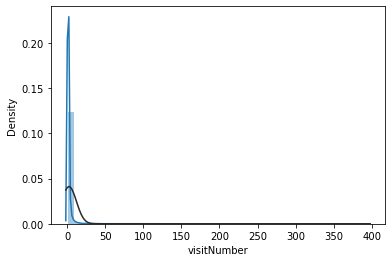

In [61]:
print(stats.kstest(df.visitNumber, 'norm', args=(df.visitNumber.mean(), df.visitNumber.std())))
sns.distplot(df.visitNumber, fit=norm)

KstestResult(statistic=0.3581287967825585, pvalue=0.0)


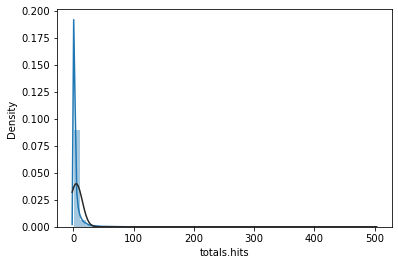

In [62]:
print(stats.kstest(df['totals.hits'], 'norm', args=(df['totals.hits'].mean(), df['totals.hits'].std())))
sns.distplot(df['totals.hits'], fit=norm)

KstestResult(statistic=0.34750207961871327, pvalue=0.0)


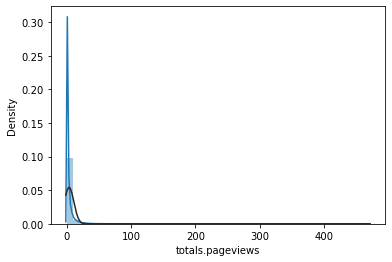

In [63]:
print(stats.kstest(df['totals.pageviews'], 'norm', args=(df['totals.pageviews'].mean(), df['totals.pageviews'].std())))
sns.distplot(df['totals.pageviews'], fit=norm)

KstestResult(statistic=0.5082985210747923, pvalue=0.0)


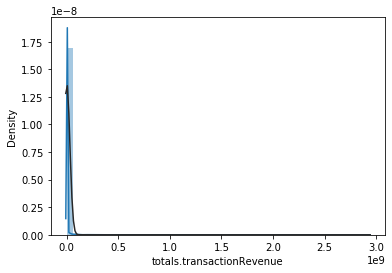

In [64]:
print(stats.kstest(df['totals.transactionRevenue'], 'norm', args=(df['totals.transactionRevenue'].mean(), df['totals.transactionRevenue'].std())))
sns.distplot(df['totals.transactionRevenue'], fit=norm)

##### Conclusion:

All predictor variables deviate from the normal distribution (H1_1, H1_2, H1_3, H1_4 and H1_5 are accepted at p-value = 0.05).

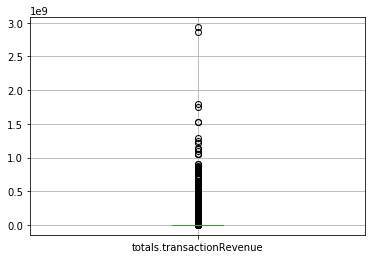

In [65]:
df.boxplot(['totals.transactionRevenue'])

Probably, there are outliers, but there are many purchases greater than 1000000000, so they are not removed. However, it is possible to get a logarithm of the price to decrease the range of values:

In [66]:
df['log_transactionRevenue'] = df.apply(lambda x: math.log(x['totals.transactionRevenue']+1), axis = 1)

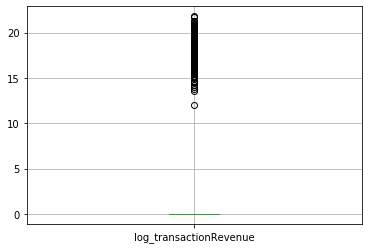

In [67]:
df.boxplot(['log_transactionRevenue'])

#### Correlation

Since most variables are not normally distributed, Spearman correlation can be used:

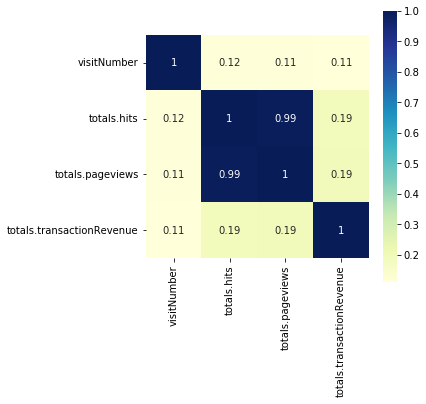

In [68]:
cor = df[['visitNumber','totals.hits','totals.pageviews','totals.transactionRevenue']].corr('spearman')
plt.figure(figsize=(5, 5))
sns.heatmap(cor, square = True, cmap='YlGnBu', annot=True)
plt.show()

It is seen that there is a linear relationship between 'totals.hits' and 'totals.pageviews'. Since one variable describes another one, one of them can be dropped:

In [69]:
df = df.drop('totals.pageviews', 1)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90365 entries, 0 to 90364
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   channelGrouping                               90365 non-null  category
 1   visitNumber                                   90365 non-null  int64   
 2   device.browser                                90365 non-null  category
 3   device.operatingSystem                        90365 non-null  category
 4   device.deviceCategory                         90365 non-null  category
 5   geoNetwork.continent                          90365 non-null  category
 6   totals.hits                                   90365 non-null  int32   
 7   totals.bounces                                90365 non-null  bool    
 8   totals.transactionRevenue                     90365 non-null  float64 
 9   trafficSource.adwordsClickInfo.adNetworkType  9036

## Relations between predictors and the dependent variable "log_transactionRevenue"

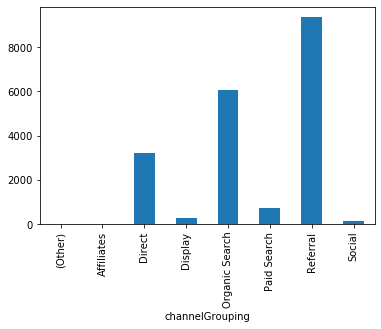

In [328]:
df.groupby('channelGrouping').sum()['log_transactionRevenue'].plot.bar()

It is seen that the most revenue is obtained throug Referral channels, while the least is obtained through social and affiliates

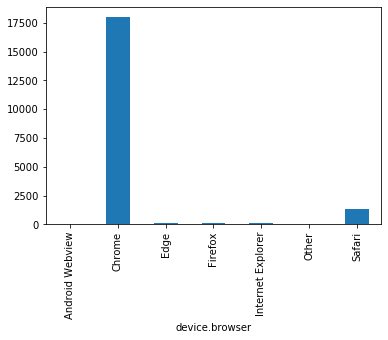

In [329]:
df.groupby('device.browser').sum()['log_transactionRevenue'].plot.bar()

Greatest purchases are made in Chrome, purchases from other browsers are much lower

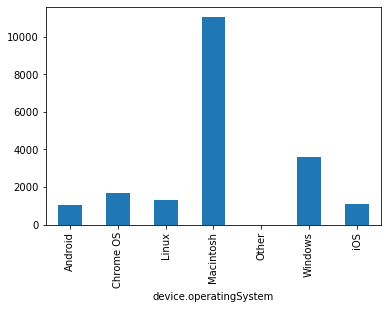

In [325]:
df.groupby('device.operatingSystem').sum()['log_transactionRevenue'].plot.bar()

Most sales are done through Macintosh

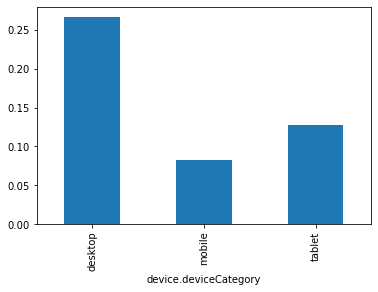

In [323]:
df.groupby('device.deviceCategory').sum()['log_transactionRevenue'].plot.bar()

Desktops outweigh all other device categories in sales

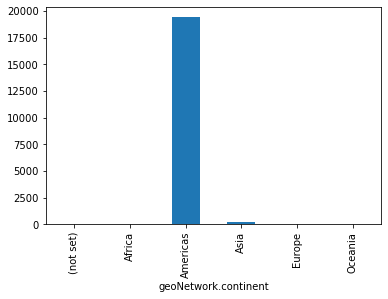

In [322]:
df.groupby('geoNetwork.continent').sum()['log_transactionRevenue'].plot.bar()

Most of the sales come from Americas

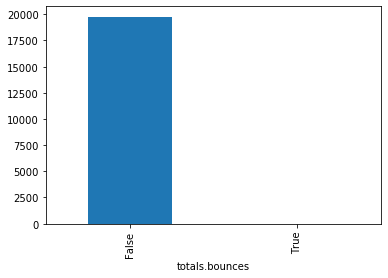

In [76]:
df.groupby('totals.bounces').sum()['log_transactionRevenue'].plot.bar()

Sells are done almost only if no cancellation is performed

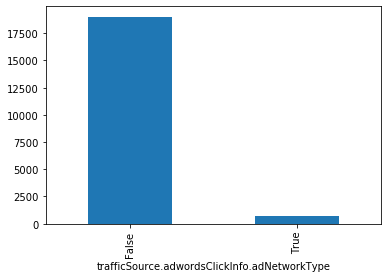

In [320]:
df.groupby('trafficSource.adwordsClickInfo.adNetworkType').sum()['log_transactionRevenue'].plot.bar()

Most of the sales are done without clicking the ads

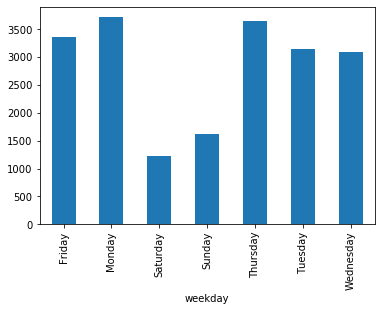

In [78]:
df.groupby('weekday').sum()['log_transactionRevenue'].plot.bar()

Lowest amount of sales is done on weekends

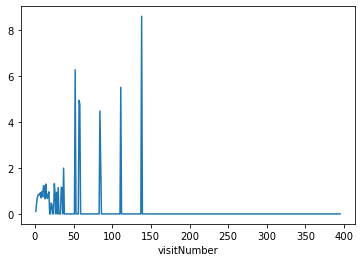

In [79]:
df.groupby('visitNumber').mean()['log_transactionRevenue'].plot()

Most sales are done at first 40 visits

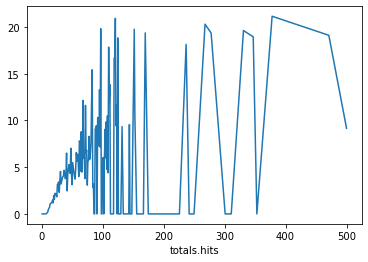

In [80]:
df.groupby('totals.hits').mean()['log_transactionRevenue'].plot()

On average, the greater a number of hits, the greater are sales

## Relations between predictors and the dependent variable "IsPurchasePerformed"

In [81]:
df["IsPurchasePerformed"] = df["totals.transactionRevenue"] > 0

In [1]:
categorical = ['channelGrouping','device.browser','device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent','totals.bounces', 'trafficSource.adwordsClickInfo.adNetworkType', 'weekday']

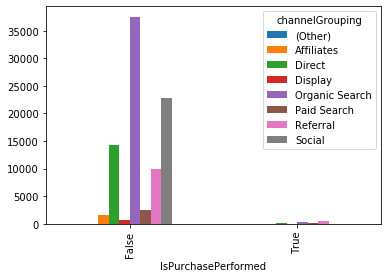

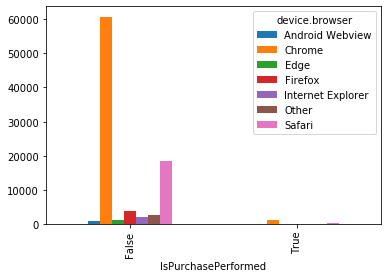

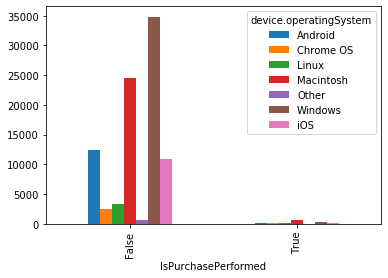

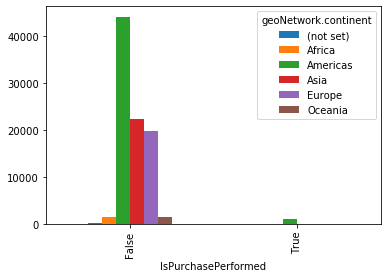

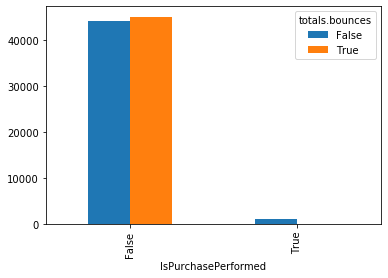

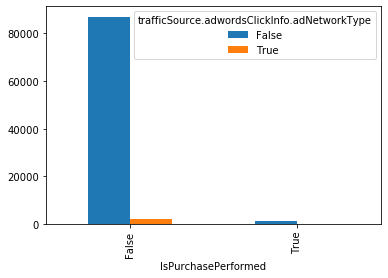

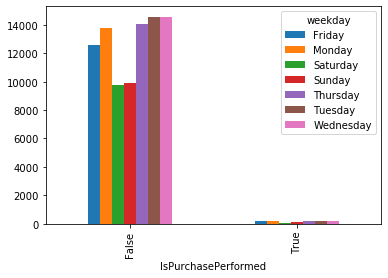

In [83]:
for c in df.columns[0:]:
    if c in categorical:
        ct = pd.crosstab(df["IsPurchasePerformed"], df[c])
        ct.plot.bar()

In [84]:
numerical = ['visitNumber','totals.hits']

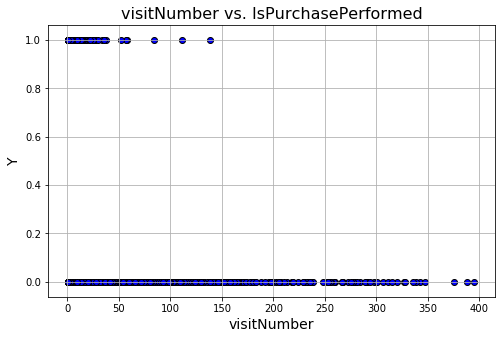

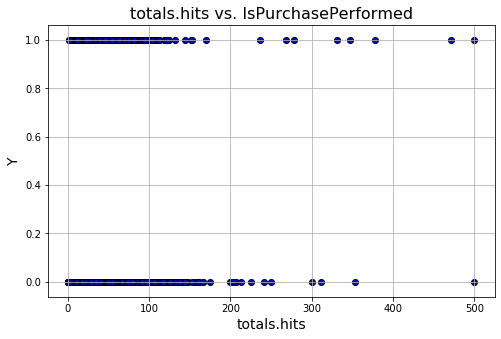

In [85]:
for c in df.columns[0:]:
    if c in numerical:
        plt.figure(figsize=(8,5))
        plt.title('{} vs. IsPurchasePerformed'.format(c), fontsize=16)
        plt.scatter(x=df[c], y=df.IsPurchasePerformed, color='blue',edgecolor='k')
        plt.grid(True)
        plt.xlabel(c, fontsize=14)
        plt.ylabel('Y', fontsize=14)
        plt.show()

In general, trends are nearly the same as for log_transactionRevenue:
- Purchases are more oftenly done through referal links
- Chrome is the main browser for making purchases
- Most purchases are done using Macintosh
- Almost all the sales are done in Americas
- If cancellation occurs, a visitor does not perform a sale
- Most sales are done without clicking on ads
- More purchases are done in working days, and less in weekends

However, there are some new insights:
- The chance to make a purchase if a visit greater than 40th is almost zero
- There is a very weak correlation between hits and a chance to perform a purchase

# Factor Analysis

We have only 2 numerical variables; thus, factor analysis is not really purposeful, but we will examine its results on 2 variables:

### Data factorability analysis

Hypothesis:

- H0: varaibles ['visitNumber', 'totals.hits'] are unrelated
- H1: variables from the aforementioned set are somehow related.

p-value: 0.05

The hypothesis is checked using Bartlett's test of sphericity.

In [86]:
df_factors = df[['visitNumber', 'totals.hits']]

In [87]:
calculate_bartlett_sphericity(df_factors)

(225.57163857830136, 5.509782299522192e-51)

#### Conclusion:

H0 is rejected since p-value is less than 0.05, so there are statistically significant relations between variables

Let us perfrom the Kaiser–Meyer–Olkin (KMO) test to determine how suited data is for factor analysis:

In [88]:
_, kmo_model = calculate_kmo(df_factors)
kmo_model

0.4999944668536874

KMO is near 0.5 (specifically with rounding), so a factor analysis can be used on this dataset, however the data is only miserably suited for the factor analysis

In [89]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax', method='principal') 
#factor model for 15 factors, which corresponds to the total number of variables
fa.fit(df_factors)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='principal', n_factors=2, rotation='varimax',
               rotation_kwargs={}, svd_method='randomized', use_smc=True)

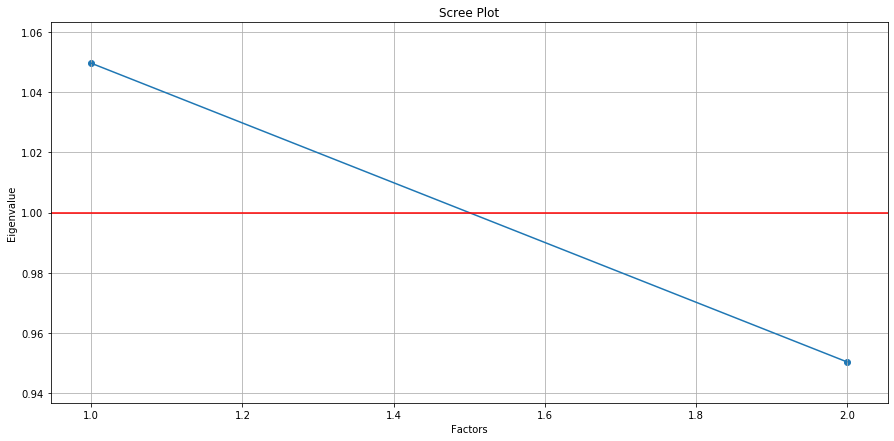

In [90]:
ev, v = fa.get_eigenvalues()
ev[ev > 1]

plt.figure(figsize=(15, 7))
plt.scatter(range(1, df_factors.shape[1]+1), ev)
plt.plot(range(1, df_factors.shape[1]+1), ev)
plt.axhline(y=1, color='r', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

#### Conclusion:

Obviously, It is better to take 1 factor since the quantity of eigenvalues > 1 is 1.

### Result factor model

In [91]:
fa = FactorAnalyzer(n_factors=1, rotation='varimax', method='principal') 
fa.fit(df_factors)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='principal', n_factors=1, rotation='varimax',
               rotation_kwargs={}, svd_method='randomized', use_smc=True)

### Communalities

To check how well variables fit into the model, the communalities are checked. If communality of a variable < 0.3, it does not fit well into the model.

In [92]:
communalities = pd.DataFrame(data=fa.get_communalities(), 
                       index=df_factors.columns, 
                       columns=['Communalities'])
communalities.sort_values('Communalities')

,Communalities
totals.hits,0.524855
visitNumber,0.524855


Variables fit well into the model, however, communalities are not very high

### Cumulative variance of the initial variables explained by the model

In [93]:
factor_variance = pd.DataFrame(data=fa.get_factor_variance()[1:3],
                              index=['Proportional variance', 'Cumulative variance'],
                              columns=['Factor 1'])
factor_variance

,Factor 1
Proportional variance,0.524855
Cumulative variance,0.524855


The model describes only 52% of variance of initial variables, which is not good enough

### Factor loading matrix

In [94]:
factors = pd.DataFrame(data=fa.loadings_, 
                       index=df_factors.columns, 
                       columns=['Factor_1'])
factors

,Factor_1
visitNumber,0.724469
totals.hits,0.724469


Both the variables provide a high impact on the model.

The only factor is described by both visitNumber and total.hits and highly correlates with both of them. The factor can be called as 'Visit number and hits'.

Factor analysis showed us that visitNumber and total.hits can be combined into 1 column, but such a column would only describe 52% variance of initial variables. KMO test showed that the data is only miserably suited for the factor analysis, so it may not be feasible to unite these two columns into one. Moreover, the graphs above show that visitNumber and total.hits correlate differently with a chance to purchase, meaning that the combination of these 2 variables can make regression models worse. Thus, it was decided not to add the obtained factor into the model

# Cluster Analysis

We first try to clusterize the whole dataset to determine the key groups of visits to the website

Normalizing data:

In [95]:
df['totals.hits_z'] = (df['totals.hits'] - df['totals.hits'].mean())/df['totals.hits'].std()

In [96]:
df['visitNumber_z'] = (df['visitNumber'] - df['visitNumber'].mean())/df['visitNumber'].std()

In [97]:
df['log_transactionRevenue_z'] = (df['log_transactionRevenue'] - df['log_transactionRevenue'].mean())/df['log_transactionRevenue'].std()

#### Using Calinski-Harabasz Index to get number of clusters

Had problems with memory (MemoryErrors if performing cluster analysis on the whole dataset; thus, taking only 50% of items)

In [98]:
df_for_numerical_clustering = df.sample(frac=0.35)

In [99]:
from sklearn.metrics import calinski_harabasz_score
Z = linkage(df_for_numerical_clustering[['totals.hits_z', 'visitNumber_z', 'log_transactionRevenue_z']], method='ward', metric='euclidean') 
labels = fcluster(Z, t=3, criterion='maxclust') #t defines the number of clusters

for k in range (2, 9):
    labels = fcluster(Z, t=k, criterion='maxclust')
    print('Number of clusters: {}, index {}'.format(k, calinski_harabasz_score(df_for_numerical_clustering[['totals.hits_z', 'visitNumber_z', 'log_transactionRevenue_z']], labels)))

Number of clusters: 2, index 20567.589292617362
Number of clusters: 3, index 21558.827654334353
Number of clusters: 4, index 23959.818599876984
Number of clusters: 5, index 28161.70394336405
Number of clusters: 6, index 31105.600605198622
Number of clusters: 7, index 32397.875747168426
Number of clusters: 8, index 35070.36149750952


Obviously, at this number of items in the dataset, the usage of dendrogram is useless (if it even can be built at this size - I honestly tried but kernel was not even able to do so). However, we can estimate correctness of choosing a number of clusters by evaluating number of elements in each cluster for different divisions on clusters:

In [100]:
for i in range(2,9):
    labels = fcluster(Z, t=i, criterion='maxclust')
    (unique, counts) = np.unique(labels, return_counts=True)
    print(i,":\n",np.asarray((unique, counts)).T)

2 :
 [[    1   398]
 [    2 31230]]
3 :
 [[    1   398]
 [    2    33]
 [    3 31197]]
4 :
 [[    1   398]
 [    2    33]
 [    3  1667]
 [    4 29530]]
5 :
 [[    1   398]
 [    2    33]
 [    3  1667]
 [    4 29262]
 [    5   268]]
6 :
 [[    1     5]
 [    2   393]
 [    3    33]
 [    4  1667]
 [    5 29262]
 [    6   268]]
7 :
 [[    1     5]
 [    2   393]
 [    3    33]
 [    4  1186]
 [    5   481]
 [    6 29262]
 [    7   268]]
8 :
 [[    1     5]
 [    2   393]
 [    3    33]
 [    4  1186]
 [    5   481]
 [    6 29262]
 [    7    69]
 [    8   199]]


Based on the information above, the most feasible division is on 5 clusters, since the choice of 6 clusters adds to index not very much, but at 6 clusters there is a cluster with only 5 elements, that is not really desirable

In [103]:
labels = fcluster(Z, t=5, criterion='maxclust')

In [104]:
df_for_numerical_clustering['culster_labels'] = labels

In [111]:
df_for_numerical_clustering.groupby('culster_labels').mean()[['visitNumber','totals.hits', 'totals.transactionRevenue']]

,visitNumber,totals.hits,totals.transactionRevenue
culster_labels,,,
1,3.133166,39.673367,1.136736e+08
2,221.757576,18.696970,0.000000e+00
3,1.950210,29.124775,0.000000e+00
4,1.577062,2.763823,0.000000e+00
5,54.835821,5.044776,0.000000e+00


In [112]:
df_for_numerical_clustering.groupby('culster_labels').agg(pd.Series.mode)[['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent', 'totals.bounces', 'trafficSource.adwordsClickInfo.adNetworkType', 'weekday', 'IsPurchasePerformed']]

,channelGrouping,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,totals.bounces,trafficSource.adwordsClickInfo.adNetworkType,weekday,IsPurchasePerformed
culster_labels,,,,,,,,,
1,Referral,Chrome,Macintosh,desktop,Americas,False,False,Friday,True
2,Organic Search,Chrome,Windows,desktop,Americas,False,False,Thursday,False
3,Organic Search,Chrome,Macintosh,desktop,Americas,False,False,Wednesday,False
4,Organic Search,Chrome,Windows,desktop,Americas,True,False,Tuesday,False
5,Organic Search,Chrome,Windows,desktop,Americas,False,False,Tuesday,False


### Description of clusters

Before the description, it is needed to say that for all clusters the main device category is desktop, continent is Americas and there are no clicks on ads.

- Cluster 1 is characterized by below average visit number (3.1), high number of total hits (39.7) and existence of sales - average transaction revenue is 113673900. The website is mainly accessed through Referral links. Most often, a browser is Chrome, an OS is Macintosh. No cancellation is faced. The visit is often performed on Fridays. Cluster name - 'Money generators' (only this cluster has purchases).

- Cluster 2 is characterized by very high visit number, below average total hits and zero revenue. The channel is mainly organic search, a browser is Chrome and OS is Windows. No cancellation is faced. Visits are most often done on Thursdays. Cluster name - 'Visits from Windows with high sequential number and without cancellation and purchases'.

- Cluster 3 is characterized by a low visit number, average total hits and zero revenue. The channel is mainly organic search, a browser is Chrome and OS is Windows. No cancellation is faced. Visits are most often done on Wednesdays. Cluster name - 'Visits from Mac with low sequential number and without cancellation and purchases'.

- Cluster 4 is charaterized by the lowest visit number, lowest total hits and zero revenue. The channel is mainly organic search, a browser is Chrome and OS is windows. Cancellation is faced. Visits are most often done on Tuesdays. Cluster name - 'Visits from Windows with lowest sequential number, lowest total hits, cancellation and without purchases'.

- Cluster 5 is charaterized by a high visit number, low total hits and zero revenue. The channel is mainly organic search, a browser is Chrome and OS is Windows. No cancellation is faced. Visits are most often done on Tuesdays. Cluster name - 'Visits from Windows with high sequential number and without cancellation and purchases'.

### Money generators - precise analysis

Here we analyze visits with successful purchases. In particular, we try to cluster visits with purchases. Since most of variables are categorical, additional techniques has to be used. The following steps are performed to perform a cluster analysis:

1. Computation of Gower distances between all the records.
2. Using Density-Based Spatial Clustering of Applications with Noise (DBSCAN) technique on the distance matrix obtained at the previous step.
3. Evaluate averages of numerical values.
4. Evaluate modes of categorical values.

In [128]:
pip install gower

  Created wheel for gower: filename=gower-0.0.5-py3-none-any.whl size=4237 sha256=474b637aa0d7e3c6f1b9a254426a166310327bcb215df9d18fad1d487143e821
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\0e\4a\62\f296d39ee4f9ffc44a8d44413dc8ce99ed022c581352312c20
Successfully built gower
Note: you may need to restart the kernel to use updated packages.


In [166]:
df_test = df[df['IsPurchasePerformed'] == True]

df_test.channelGrouping = df_test.channelGrouping.astype("object")
df_test['device.browser'] = df_test['device.browser'].astype("object")
df_test['device.operatingSystem'] = df_test['device.operatingSystem'].astype("object")
df_test['device.deviceCategory'] = df_test['device.deviceCategory'].astype("object")
df_test['geoNetwork.continent'] = df_test['geoNetwork.continent'].astype("object")
df_test['weekday'] = df_test['weekday'].astype("object")

In [167]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1102 entries, 45 to 90247
Data columns (total 16 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   channelGrouping                               1102 non-null   object 
 1   visitNumber                                   1102 non-null   int64  
 2   device.browser                                1102 non-null   object 
 3   device.operatingSystem                        1102 non-null   object 
 4   device.deviceCategory                         1102 non-null   object 
 5   geoNetwork.continent                          1102 non-null   object 
 6   totals.hits                                   1102 non-null   int32  
 7   totals.bounces                                1102 non-null   bool   
 8   totals.transactionRevenue                     1102 non-null   float64
 9   trafficSource.adwordsClickInfo.adNetworkType  1102 non-null  

In [168]:
df_for_full_clustering = df_test[['channelGrouping','device.browser','device.operatingSystem','geoNetwork.continent','totals.bounces', 'trafficSource.adwordsClickInfo.adNetworkType', 'weekday', 'visitNumber_z', 'totals.hits_z', 'log_transactionRevenue_z']]

In [169]:
import gower

distance_matrix = gower.gower_matrix(df_for_full_clustering)

In [176]:
from sklearn.cluster import DBSCAN

dbscan_cluster = DBSCAN(eps=0.2, 
                        min_samples=2, 
                        metric="precomputed")

dbscan_cluster.fit(distance_matrix)

#df_test["cluster"] = dbscan_cluster.labels_

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

In [178]:
df_test["cluster"] = dbscan_cluster.labels_

In [186]:
df_test.groupby('cluster').mean()

,visitNumber,totals.hits,totals.bounces,totals.transactionRevenue,trafficSource.adwordsClickInfo.adNetworkType,log_transactionRevenue,IsPurchasePerformed,totals.hits_z,visitNumber_z,log_transactionRevenue_z
cluster,,,,,,,,,,
-1,106.000000,50.000000,0.0,9.074100e+08,0.0,19.080876,1.0,4.623130,11.080859,9.624573
0,3.616477,37.245265,0.0,1.338564e+08,0.0,17.828311,1.0,3.324130,0.141602,8.985492
1,2.512195,32.634146,0.0,6.645415e+07,1.0,17.421149,1.0,2.854513,0.023614,8.777750
2,1.500000,38.000000,0.0,1.644000e+07,1.0,16.529090,1.0,3.400996,-0.084535,8.322605


In [185]:
df_test.groupby('cluster').agg(pd.Series.mode)

,channelGrouping,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,totals.bounces,trafficSource.adwordsClickInfo.adNetworkType,weekday,IsPurchasePerformed
cluster,,,,,,,,,
-1,"[Direct, Display, Social]","[Android Webview, Edge, Firefox]",Windows,desktop,Americas,False,False,Friday,True
0,Referral,Chrome,Macintosh,desktop,Americas,False,False,Tuesday,True
1,Paid Search,Chrome,Macintosh,desktop,Americas,False,True,Wednesday,True
2,Paid Search,Firefox,Windows,desktop,Americas,False,True,"[Friday, Tuesday]",True


### Description of clusters:

Firstly, it is worth mentioning that the algorithm detected outliers and did not accounted for them. Such outliers have visitNumber > 100 and total hits nearly 50, which seems as an obvious outlier. Transaction revenue for this cluster is the highest (> 900000000). Such a cluster also considers channels and browsers that are rarely used for purchases. As for other properties they are quite similar to other clusters. We call this cluster as simple as it is - 'Outliers'.

- Cluster 0 is characterized by above average visit number (3.6), quite high total hits and very high transaction revenue. Visits from this cluster do not usually have clicks on ads. Website is accessed using referral links. Browser is Chrome and OS is Mac. Visits from this group are more often on Tuesdays. Such a cluster can be called as 'Referral visits from Chrome and Mac with most profits'.

- Cluster 1 is characterized by nearly average visit number (2.5), sufficiently low total hits and medium transaction revenue. Visits from this cluster more often have clicks on ads. Website is accessed with a Paid Search. A browser is Chrome and OS is Mac. Visits from this group are more often on Wednesday. Such a cluster can be called as 'Paid search visits from Chrome and Mac with medium profits'.

- Cluster 2 is characterized by quite a low visit number (1.5), quite high total hits number and lower transaction revenue. Visits from this cluster more often have clicks on ads. Website is accessed using a Paid Search. A browser is Firefox and OS is Windows. Visits from this group are more often on Fridays and Tuesdays. Such a cluster can be called as 'Newcomer paid search visits from Firefox and Windows with lower profits'

# Regression analysis

Here, to solve research questions, we perform 2 regression analysis:
- Linear regression to determine relationship between predictors and a revenue obtained from the visit.
- Binary logistic regression to determine relationship between predictors and a chance to perform a transaction.

## Linear regression

H0: The linear regression model constructed for a dependent variable 'log_transactionRevenue' and the following predictors:
- 'channelGrouping', 
- 'device.browser', 
- 'device.operatingSystem', 
- 'device.deviceCategory', 
- 'geoNetwork.continent', 
- 'weekday',
- 'visitNumber',
- 'totals.hits',
- 'totals.bounces',
- 'trafficSource.adwordsClickInfo.adNetworkType'

explains the variation of 'log_transactionRevenue'.

H1: The aforementioned model does not explain the variation of 'log_transactionRevenue'.

p-value = 0.05.

The hypothesis can be checked based on R^2 of the model as well as based on the results of F-test

In [183]:
df_with_purchases = df[df['IsPurchasePerformed']]

In [205]:
df_for_regression = pd.get_dummies(df_with_purchases, columns=['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent', 'weekday'], drop_first = True)
df_for_regression = df_for_regression.drop('device.browser_Chrome', 1) # get_dummies drops a column without true values for device.browser
df_for_regression = df_for_regression.drop(['totals.transactionRevenue', 'IsPurchasePerformed', 'totals.hits_z', 'visitNumber_z', 'log_transactionRevenue_z'], 1)

In [206]:
df_for_regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1111 entries, 164 to 90318
Data columns (total 36 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   visitNumber                                   1111 non-null   int64  
 1   totals.hits                                   1111 non-null   int32  
 2   totals.bounces                                1111 non-null   bool   
 3   trafficSource.adwordsClickInfo.adNetworkType  1111 non-null   bool   
 4   log_transactionRevenue                        1111 non-null   float64
 5   channelGrouping_Affiliates                    1111 non-null   uint8  
 6   channelGrouping_Direct                        1111 non-null   uint8  
 7   channelGrouping_Display                       1111 non-null   uint8  
 8   channelGrouping_Organic Search                1111 non-null   uint8  
 9   channelGrouping_Paid Search                   1111 non-null 

In [207]:
df_predictors = df_for_regression.drop('log_transactionRevenue',1)
df_dependent = df_for_regression['log_transactionRevenue']

In [208]:
df_predictors_constant = sm.add_constant(df_predictors)

In [209]:
model = sm.OLS(df_dependent, df_predictors_constant.astype(float)).fit()

In [210]:
print('R^2 = {:f}'.format(model.rsquared))
print('F-test significance = {:f}'.format(model.f_pvalue))

R^2 = 0.171640
F-test significance = 0.000000


Although the model is not very good, since it describes only 17% variance of the dependent variable, it is still significant. H1 is rejected.

We can also estimate the what would happen if the dependent variable is without normalization with the logarithm:

In [211]:
df_dependent_test = df_with_purchases['totals.transactionRevenue']

model_test = sm.OLS(df_dependent_test, df_predictors_constant.astype(float)).fit()

print('R^2 = {:f}'.format(model_test.rsquared))
print('F-test significance = {:f}'.format(model_test.f_pvalue))

R^2 = 0.135186
F-test significance = 0.000000


As is seen, the model with a normalized dependent variable has a higher R^2; thus, we will use the first model further

#### Conclusion:

The model with a normalized dependent variable is statistically significant and explains 17% of variance of variable 'log_transactionRevenue'. H1 is rejected at p-value = 0.05

### Model Characteristics

- H0_1: The variable visitNumber is statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H0_2: The variable totals.hits is statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H0_3: The variable totals.bounces is statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H0_4: The variable trafficSource.adwordsClickInfo.adNetworkType is statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H0_5: The variable channelGrouping is statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H0_6: The variable device.browser is statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H0_7: The variable device.operatingSystem is statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H0_8: The variable device.deviceCategory is statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H0_9: The variable geoNetwork.continent is statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H0_10: The variable weekday is statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'



- H1_1: The variable visitNumber is not statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H1_2: The variable totals.hits is not statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H1_3: The variable totals.bounces is not statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H1_4: The variable trafficSource.adwordsClickInfo.adNetworkType is not statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H1_5: The variable channelGrouping is not statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H1_6: The variable device.browser is not statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H1_7: The variable device.operatingSystem is not statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H1_8: The variable device.deviceCategory is not statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H1_9: The variable geoNetwork.continent is not statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'
- H1_10: The variable weekday is not statistically significant for the linear regression model constructed for a dependent variable 'log_transactionRevenue'

p-value = 0.05

The hypothesis can be checked by estimating p-values of each variable in the constructed model

In [212]:
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     log_transactionRevenue   R-squared:                       0.172
Model:                                OLS   Adj. R-squared:                  0.148
Method:                     Least Squares   F-statistic:                     7.212
Date:                    Wed, 01 Jun 2022   Prob (F-statistic):           1.05e-27
Time:                            21:17:27   Log-Likelihood:                -1698.4
No. Observations:                    1111   AIC:                             3461.
Df Residuals:                        1079   BIC:                             3621.
Df Model:                              31                                         
Covariance Type:                nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [213]:
print(f'Statistically significant model parameters: {model.pvalues[model.pvalues < 0.05].index.values}')

Statistically significant model parameters: ['const' 'visitNumber' 'totals.hits']


As is seen, the only statistically significant predictors are 'visitNumber' and 'totals.hits'.
H1_1, H1_2 are rejected, H1_3, H1_4, H1_5, H1_6, H1_7, H1_8, H1_9, H1_10 are accepted.

#### Regression equation

In [284]:
l = []
for (param, index) in zip(model.params[1:], model.params.index[1:]):
    l.append('{:.2f}*{}'.format(param, index))
    
print('Y = {:2f} + {}'.format(model.params[0], ' + '.join(l)))

Y = -19.548976 + -0.00*visitNumber + 0.06*totals.hits + -61.54*totals.bounces + 1326.40*trafficSource.adwordsClickInfo.adNetworkType + -17.58*channelGrouping_Affiliates + -1.50*channelGrouping_Direct + -1.58*channelGrouping_Display + -1.70*channelGrouping_Organic Search + -1328.06*channelGrouping_Paid Search + -0.99*channelGrouping_Referral + -3.82*channelGrouping_Social + 15.98*device.browser_Chrome + 16.23*device.browser_Edge + 14.48*device.browser_Firefox + 16.00*device.browser_Internet Explorer + 16.05*device.browser_Other + 15.50*device.browser_Safari + 1.65*device.operatingSystem_Chrome OS + 1.44*device.operatingSystem_Linux + 1.87*device.operatingSystem_Macintosh + -12.64*device.operatingSystem_Other + 1.20*device.operatingSystem_Windows + 0.34*device.operatingSystem_iOS + 0.97*device.deviceCategory_mobile + 1.20*device.deviceCategory_tablet + -1.13*geoNetwork.continent_Africa + -0.39*geoNetwork.continent_Americas + -3.45*geoNetwork.continent_Asia + -5.19*geoNetwork.continent_Eu

Since the dependent variable is in the form log(y + 1), we have to count the actual coefficient as (100% * coef), which is approximation, or as (100% * (e ^ coef - 1)), which is a precise answer (see https://stats.stackexchange.com/questions/242774/linear-regression-with-logarithmic-dependent-variable):

In [214]:
coefs = pd.DataFrame()
coefs['Coefs'] = model.params[1:]
coefs['Coefs'] = (np.exp(coefs['Coefs']) - 1) * 100
coefs['Features'] = model.params.index[1:]
coefs.set_index('Features', inplace=True)
coefs

,Coefs
Features,
visitNumber,1.215333e+00
totals.hits,7.963286e-01
totals.bounces,-2.220446e-14
trafficSource.adwordsClickInfo.adNetworkType,7.298488e+01
channelGrouping_Affiliates,2.220446e-14
channelGrouping_Direct,2.618645e+02
channelGrouping_Display,1.475460e+02
channelGrouping_Organic Search,1.276059e+02
channelGrouping_Paid Search,7.298488e+01


Statistically significant predictors are 'visitNumber', 'totals.hits' and 'device.browser'. Here is an interpretation for them:

- Let's consider the coefficient on the variable visitNumber. The actual coefficient for the variable is positive and equals 1.21. It can be concluded that an increase in visitNumber by one, on average, leads to an increase of the revenue by 1.21%.

- Let's consider the coefficient on the variable totals.hits. The actual coefficient for the variable is negative and equals 0.79. It can be concluded that an increase in totals.hits by one, on average, leads to an increase of the revenue by 0.79%.

## Model Diagnostics

#### Residuals

To evaluate how he model fits the sample data, the residuals can be calculated. Small residuals show that fits the sample data well.

##### Hypothesis:

H1: The distribution of residuals is different from the normal distribution

H0: The distribution of residuals is not different from the normal distribution

p-value = 0.05

In [215]:
p = stats.kstest(model.resid, 'norm', args=(model.resid.mean(), model.resid.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.103


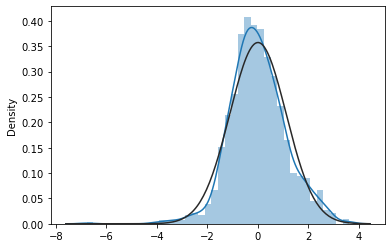

In [216]:
sns.distplot(model.resid, fit=stats.norm) 

##### Conclusion:

H1 is rejected at p-value = 0.05: the distribution of residuals is not different from the normal distribution.

#### Multicollinearity

Multicollinearity can be checked to find any strong correlations between predictors

In [217]:
vifs = np.array([vif(model.model.exog, i) for i in range(model.model.exog.shape[1])])

vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
12,1.022742,device.browser_Firefox
11,1.057410,device.browser_Edge
1,1.066152,totals.hits
0,1.076530,visitNumber
14,1.101549,device.browser_Other
30,1.309142,weekday_Saturday
13,1.396698,device.browser_Internet Explorer
31,1.400026,weekday_Sunday
33,1.653327,weekday_Tuesday
34,1.654966,weekday_Wednesday


Indeed, the model has significant problems with multicollinearity. In particular, dummy variables from channelGrouping, geoNetwork.continent, device.deviceCategory, device.browser and device.operatingSystem have enourmously high VIFs. We can try to solve this problem after a full diagnosis of the model. For some columns, there exist no actual values in the dataset

### Heteroscedasticity

To check the well-fitness of the model, the heteroscedasticity can be evaluated. If the model is well-fitted, there should be no pattern to the residuals plotted against the fitted values.

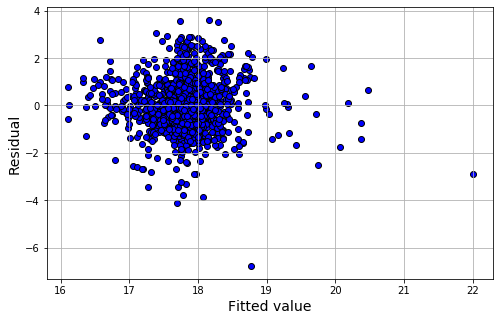

In [219]:
plt.figure(figsize=(8,5))
plt.scatter(x=model.fittedvalues, y=model.resid, color='blue', edgecolor='k')
plt.grid(True)
plt.xlabel('Fitted value', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.show()

##### Conclusion:

According to the plot and the results of Durbin-Watson test, the model is rather homoscedastical (but still near the border)

### Outliers and influential cases

Influential cases can be detected using DFFITS techniqe. Outliers can be detected by checking the standardized residuals of cases in the sample

In [220]:
influence = model.get_influence()
inf_sum = influence.summary_frame()
inf_sum

,dfb_const,dfb_visitNumber,dfb_totals.hits,dfb_totals.bounces,dfb_trafficSource.adwordsClickInfo.adNetworkType,dfb_channelGrouping_Affiliates,dfb_channelGrouping_Direct,dfb_channelGrouping_Display,dfb_channelGrouping_Organic Search,dfb_channelGrouping_Paid Search,...,dfb_weekday_Sunday,dfb_weekday_Thursday,dfb_weekday_Tuesday,dfb_weekday_Wednesday,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
164,-0.012605,0.005717,0.011976,-0.817727,0.005775,0.117349,0.001422,0.000375,-0.002782,0.005775,...,0.008207,0.009977,0.004197,-0.000893,0.001117,-1.249537,0.025118,-0.200570,-1.249863,-0.200622
226,-0.001402,-0.017407,-0.022438,-0.190358,0.000931,-0.100094,0.001337,0.001578,0.001205,0.000931,...,-0.001452,-0.001664,-0.001252,-0.002033,0.000306,-1.292848,0.006544,-0.104927,-1.293251,-0.104959
312,-0.001768,0.007611,0.019705,-1.060966,0.001688,0.272332,0.001250,0.000292,0.001037,0.001688,...,-0.002440,-0.001063,-0.000479,-0.066247,0.000298,-1.164141,0.007845,-0.103516,-1.164333,-0.103533
498,-0.001096,0.005211,0.008662,0.362257,0.000119,0.534703,0.000209,-0.000035,0.000176,0.000119,...,-0.001431,-0.000688,0.000013,-0.000384,0.000102,-0.768027,0.006180,-0.060563,-0.767881,-0.060551
518,-0.000649,0.000481,0.001686,-1.535206,0.000575,-0.888222,-0.000387,0.000209,0.000213,0.000575,...,0.000247,-0.004681,0.000371,-0.000104,0.000008,-0.104037,0.026496,-0.017164,-0.103990,-0.017156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90132,-0.001225,0.010434,0.007371,0.362655,0.000199,-0.332835,0.000248,-0.000134,0.000250,0.000199,...,-0.001792,-0.000935,-0.000040,-0.000575,0.000145,-0.915090,0.006207,-0.072317,-0.915021,-0.072311
90149,-0.006580,0.034044,0.019943,0.321839,-0.000170,-0.487045,-0.001308,-0.003469,-0.001164,-0.000170,...,0.002458,0.083835,0.001750,0.002457,0.000543,1.634866,0.007266,0.139867,1.636136,0.139976
90225,-0.001854,-0.000127,0.006779,-0.446014,-0.000071,0.142631,-0.000259,-0.000630,-0.000295,-0.000071,...,0.000887,0.022599,0.000443,0.000723,0.000037,0.438547,0.006836,0.036385,0.438383,0.036371
90310,0.004435,-0.004771,0.013667,-0.536415,-0.006205,0.859314,-0.005116,-0.004404,-0.008581,-0.006205,...,0.002061,0.001549,-0.047704,0.002355,0.000235,-0.880442,0.010801,-0.092000,-0.880350,-0.091990


#### Potential influential cases

Such cases can be found using difference in fit(s) diagnostic (DFFITS). DFFITS value shows how influential a particual case on the whole model

In [221]:
inf_sum['dffits'][(inf_sum['dffits']>1) | (inf_sum['dffits']<-1)].sort_values()

89759   -9.418918
64511   -2.132188
75133   -1.841249
38408   -1.270915
20919   -1.251585
18047   -1.237849
60703   -1.087860
57884   -1.023696
36657    1.444478
39077    2.132188
Name: dffits, dtype: float64

There are not many such cases and dffits is not very high for most of them

#### Potential outliers

Based on standardized residuals, it is possible to identify outliers (whose value has to be less than -3 or greater than 3)

In [222]:
inf_sum['standard_resid'][(inf_sum['standard_resid']>3) | (inf_sum['standard_resid']<-3)].sort_values()

23570   -6.053142
27695   -3.649575
20919   -3.602228
31487   -3.349837
57884   -3.205918
30631   -3.046838
28768    3.116744
40028    3.141958
61551    3.219847
Name: standard_resid, dtype: float64

Here is only one significant outlier with |residuals| > 4

#### Conclusions:

The quantity of influetial cases and outliers is sufficiently low: amount of influential cases is 10, amount of outliers is 9. Moreover, only one outlier has |residuals| > 4 and only one influential case has |dffits| > 2.5. That means that the influence of such influential cases and outliers is not very high on the model.

### A model with fixed problems - removing columns that give huge multicollinearity

In [255]:
df_for_final_regression = df_with_purchases[['totals.hits', 'visitNumber', 'device.browser', 'weekday', 'device.operatingSystem', 'log_transactionRevenue']]

In [256]:
df_for_final_regression = pd.get_dummies(df_for_final_regression, columns=['device.browser', 'weekday', 'device.operatingSystem'], drop_first = True)
df_for_final_regression = df_for_final_regression.drop('device.operatingSystem_Other', 1) # No values with device.operatingSystem = Other
df_for_final_regression = df_for_final_regression.drop('device.browser_Chrome', 1) # get_dummies drops a column without true values for device.browser

In [257]:
df_predictors = df_for_final_regression.drop('log_transactionRevenue',1)
df_dependent = df_for_final_regression['log_transactionRevenue']
df_predictors_constant = sm.add_constant(df_predictors)
model = sm.OLS(df_dependent, df_predictors_constant.astype(float)).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     log_transactionRevenue   R-squared:                       0.139
Model:                                OLS   Adj. R-squared:                  0.124
Method:                     Least Squares   F-statistic:                     9.763
Date:                    Wed, 01 Jun 2022   Prob (F-statistic):           1.30e-25
Time:                            21:38:50   Log-Likelihood:                -1720.1
No. Observations:                    1111   AIC:                             3478.
Df Residuals:                        1092   BIC:                             3574.
Df Model:                              18                                         
Covariance Type:                nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

Model is statistically significant and describes 14% of variance of the dependent variable (worse than the previous model). Statistically significant variables: totals.hits and visitNumber. Device.browser and Device.operatingSystem are only partially significant. Coefficients for total.hits and visitNumber are very close to coefficients of the previous model

#### Residuals

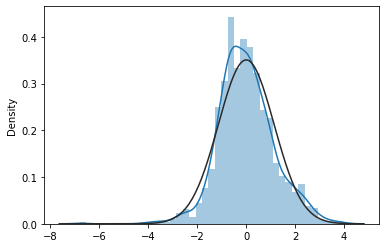

In [258]:
sns.distplot(model.resid, fit=stats.norm) 

Distribution of residuals is not different from normal

#### Heteroscedasticity

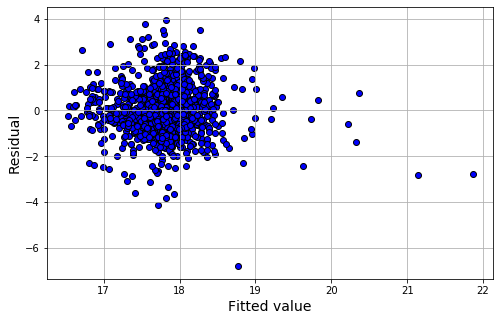

In [259]:
plt.figure(figsize=(8,5))
plt.scatter(x=model.fittedvalues, y=model.resid, color='blue', edgecolor='k')
plt.grid(True)
plt.xlabel('Fitted value', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.show()

According to the plot and the results of Durbin-Watson test, the model is rather homoscedastical (but still near the border)

#### Multicollinearity

In [253]:
vifs = np.array([vif(model.model.exog, i) for i in range(model.model.exog.shape[1])])

vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
3,1.019124,device.browser_Firefox
2,1.036909,device.browser_Edge
0,1.041583,totals.hits
4,1.044770,device.browser_Internet Explorer
1,1.050178,visitNumber
5,1.084503,device.browser_Other
8,1.291708,weekday_Saturday
9,1.383187,weekday_Sunday
12,1.633253,weekday_Wednesday
11,1.643887,weekday_Tuesday


The problem of multicollinearity does not exist now

## Conclusion

The linear regression model can be used to describe relationship between predictors and 'log_transactionRevenue'. The usage of logarithmic dependent variable allows to increase the quality of the model. However, the presented models still describe less than 20% of variance of the dependent variable. Models show that only 2 variables are statistically significant: total.hits and visitNumber. Overall, it is possible to say that an increase of any of these variables leads to an increase of the transactionRevenue. The result models do not have problems with residuals and heteroscedasticity, while the quantity of outliers and influentials is quite low. The second model shows how the problem of multicollinearity can be solved (with a small loss of R^2)

## Binary logistic regression

H0: The binary logistic regression model constructed for a dependent variable 'IsPurchasePerformed' and the following predictors:
- 'channelGrouping', 
- 'device.browser', 
- 'device.operatingSystem', 
- 'device.deviceCategory', 
- 'geoNetwork.continent', 
- 'weekday',
- 'visitNumber',
- 'totals.hits',
- 'totals.bounces',
- 'trafficSource.adwordsClickInfo.adNetworkType'

explains the variation of 'IsPurchasePerformed'.

H1: The aforementioned model does not explain the variation of 'IsPurchasePerformed'.

p-value = 0.05.

In [280]:
df_for_regression = pd.get_dummies(df, columns=['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent', 'weekday'], drop_first = True)
df_for_regression = df_for_regression.drop(['totals.transactionRevenue', 'log_transactionRevenue', 'totals.hits_z', 'visitNumber_z', 'log_transactionRevenue_z'], 1)
df_for_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90365 entries, 0 to 90364
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype
---  ------                                        --------------  -----
 0   visitNumber                                   90365 non-null  int64
 1   totals.hits                                   90365 non-null  int32
 2   totals.bounces                                90365 non-null  bool 
 3   trafficSource.adwordsClickInfo.adNetworkType  90365 non-null  bool 
 4   IsPurchasePerformed                           90365 non-null  bool 
 5   channelGrouping_Affiliates                    90365 non-null  uint8
 6   channelGrouping_Direct                        90365 non-null  uint8
 7   channelGrouping_Display                       90365 non-null  uint8
 8   channelGrouping_Organic Search                90365 non-null  uint8
 9   channelGrouping_Paid Search                   90365 non-null  uint8
 10  channelGro

In [281]:
df_predictors = df_for_regression.drop('IsPurchasePerformed',1)
df_dependent = df_for_regression['IsPurchasePerformed']

In [282]:
df_predictors_constant = sm.add_constant(df_predictors)

In [283]:
model = sm.Logit(df_dependent, df_predictors_constant.astype(float)).fit()
print(model.summary())

         Current function value: 0.039966
         Iterations: 35


C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            Logit Regression Results                           
Dep. Variable:     IsPurchasePerformed   No. Observations:                90365
Model:                           Logit   Df Residuals:                    90328
Method:                            MLE   Df Model:                           36
Date:                 Wed, 01 Jun 2022   Pseudo R-squ.:                  0.3972
Time:                         22:15:37   Log-Likelihood:                -3611.5
converged:                       False   LL-Null:                       -5991.0
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                          -19.5490   2647.706     -0.007      0.994   -5208.958    5169.860
visitNumber          

##### Conclusion:

Appears that some variables completely describe the chance to perform a purchase. The result model is statistically significant and describes 40% variance of the output variable, so H1 is rejected.

### Parameter significance

Hypotheses:

- H0_1: The variable visitNumber is statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H0_2: The variable totals.hits is statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H0_3: The variable totals.bounces is statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H0_4: The variable trafficSource.adwordsClickInfo.adNetworkType is statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H0_5: The variable channelGrouping is statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H0_6: The variable device.browser is statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H0_7: The variable device.operatingSystem is statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H0_8: The variable device.deviceCategory is statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H0_9: The variable geoNetwork.continent is statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H0_10: The variable weekday is statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'

- H1_1: The variable visitNumber is not statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H1_2: The variable totals.hits is not statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H1_3: The variable totals.bounces is not statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H1_4: The variable trafficSource.adwordsClickInfo.adNetworkType is not statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H1_5: The variable channelGrouping is not statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H1_6: The variable device.browser is not statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H1_7: The variable device.operatingSystem is not statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H1_8: The variable device.deviceCategory is not statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H1_9: The variable geoNetwork.continent is not statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'
- H1_10: The variable weekday is not statistically significant for the logistic regression model constructed for a dependent variable 'IsPurchasePerformed'

p-value = 0.05

In [265]:
print(f'Statistically significant model parameters: {model.pvalues[model.pvalues < 0.05].index.values}')

Statistically significant model parameters: ['totals.hits' 'channelGrouping_Social' 'device.operatingSystem_Chrome OS'
 'device.operatingSystem_Macintosh' 'geoNetwork.continent_Asia'
 'geoNetwork.continent_Europe' 'weekday_Saturday' 'weekday_Tuesday']


#### Conclusion:

'totals.hits' is the only variable that is completely statistically significant. Variables 'channelGrouping', 'device.operatingSystem', 'geoNetwork.continent' and 'weekday' are only partially significant. H1_2 is rejected, H1_1, H1_3, H1_4, H1_5, H1_6, H1_7, H1_8, H1_9 and H1_10 are rejected.

### Regression equation

In [285]:
l = []
for (param, index) in zip(model.params[1:], model.params.index[1:]):
    l.append('{:.2f}*{}'.format(param, index))
    
print('logit(p) = {:2f} + {}'.format(model.params[0], ' + '.join(l)))

logit(p) = -19.548976 + -0.00*visitNumber + 0.06*totals.hits + -61.54*totals.bounces + 1326.40*trafficSource.adwordsClickInfo.adNetworkType + -17.58*channelGrouping_Affiliates + -1.50*channelGrouping_Direct + -1.58*channelGrouping_Display + -1.70*channelGrouping_Organic Search + -1328.06*channelGrouping_Paid Search + -0.99*channelGrouping_Referral + -3.82*channelGrouping_Social + 15.98*device.browser_Chrome + 16.23*device.browser_Edge + 14.48*device.browser_Firefox + 16.00*device.browser_Internet Explorer + 16.05*device.browser_Other + 15.50*device.browser_Safari + 1.65*device.operatingSystem_Chrome OS + 1.44*device.operatingSystem_Linux + 1.87*device.operatingSystem_Macintosh + -12.64*device.operatingSystem_Other + 1.20*device.operatingSystem_Windows + 0.34*device.operatingSystem_iOS + 0.97*device.deviceCategory_mobile + 1.20*device.deviceCategory_tablet + -1.13*geoNetwork.continent_Africa + -0.39*geoNetwork.continent_Americas + -3.45*geoNetwork.continent_Asia + -5.19*geoNetwork.conti

### Regression coefficients interpretation

In [286]:
coefs = pd.DataFrame()
coefs['Coefs'] = model.params[1:]
coefs['Features'] = model.params.index[1:]
coefs.set_index('Features', inplace=True)
coefs['OddsRatio'] = np.exp(coefs.Coefs)
coefs

,Coefs,OddsRatio
Features,,
visitNumber,-0.001823,9.981786e-01
totals.hits,0.055955,1.057550e+00
totals.bounces,-61.544905,1.868045e-27
trafficSource.adwordsClickInfo.adNetworkType,1326.400681,inf
channelGrouping_Affiliates,-17.575547,2.328289e-08
channelGrouping_Direct,-1.498878,2.233807e-01
channelGrouping_Display,-1.580643,2.058427e-01
channelGrouping_Organic Search,-1.704079,1.819399e-01
channelGrouping_Paid Search,-1328.064027,0.000000e+00


Statistically significant model parameters: ['totals.hits' 'channelGrouping_Social' 'device.operatingSystem_Chrome OS'
 'device.operatingSystem_Macintosh' 'geoNetwork.continent_Asia'
 'geoNetwork.continent_Europe' 'weekday_Saturday' 'weekday_Tuesday']. Description for them:
 
 - One hit increase in totals.hits will increase the odds to make a purchase by 6%.
 - For visits from social channels the odds to perform a purchase are 98% lower than for visits from non-detected channels (from group 'other')
 - For visits from Chrome OS the odds to perform a purchase are 5 times higher than for visits from Androids.
 - For visits from Mac the odds to perform a purchase are 6.5 times higher than for visits from Androids.
 - For visits made from Asia the odds to perform a purchase are 97% lower than for visits from a the non-set continent.
 - For visits made from Europe the odds to perform a purchase are 99% lower than for visits from a the non-set continent.
 - For visits made on Saturdays the odds to perform a purchase are 35% lower than for visits on Fridays.
 - For visits made on Tuesdays the odds to perform a purchase are 25% lower than for visits on Fridays.

### Confusion matrix

In [287]:
cm = model.pred_table()
print('TP: {} | FN: {}\n-------------------\nFP: {}  | TN: {}'.format(cm[0,0], cm[0,1], cm[1,0], cm[1,1]))

TP: 89123.0 | FN: 131.0
-------------------
FP: 998.0  | TN: 113.0


It is seen that the quantity of correctly determined cases is quite high, but the quantity of true-negatives is still quite low.

In [288]:
accuracy = (cm[0,0] + cm[1,1]) / sum(sum(cm))
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.9875062247551596


Although accuracy is 0.99, we should remember that a chance to perform a purchase is nearly 1.4%, meaning that if a model would always answer than a purchase won't be done, it would still obtain accuracy > 0.98. Looking only at the accuracy, we can say that the model fits the data well, but we should properly consider the cases when a purchase is actually done. According to proportion of FP and FN to TN, we can say that the model does not fit the data well in terms of successful purchases

### ROC-curve

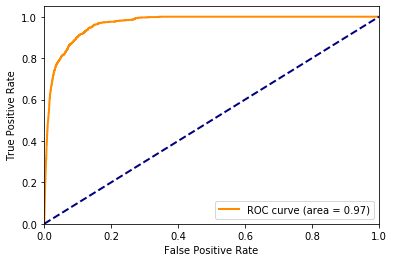

In [291]:
fpr, tpr, _ = roc_curve(df_dependent, model.predict())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

AUC is quite high due to very high accuracy. However, in our case, it does not show the actual picture. It is seen that actually model predicts less than 50% of successful purchases

In [292]:
df_for_regression['probability'] = model.predict()

###  Model Diagnostics

#### Residuals

##### Hypothesis:

H1: The distribution of residuals is different from the normal distribution

H0: The distribution of residuals is not different from the normal distribution

p-value = 0.05

In [301]:
p = stats.kstest(model.resid_generalized, 'norm', args=(model.resid_generalized.mean(), model.resid_generalized.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.000


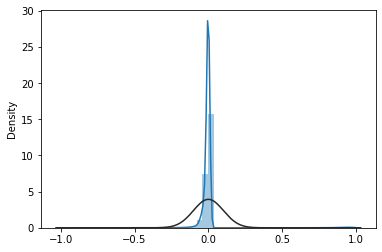

In [302]:
sns.distplot(model.resid_generalized, fit=stats.norm) 

##### Conclusion:

H1 is accepted at p-value = 0.05 : residuals significantly differ from the normal distribution.

#### Multicollinearity

Multicollinearity can be checked to find any strong correlations between predictors

In [303]:
vifs = np.array([vif(model.model.exog, i) for i in range(model.model.exog.shape[1])])

vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
0,1.021202,visitNumber
1,1.178921,totals.hits
2,1.219166,totals.bounces
20,1.307922,device.operatingSystem_Other
31,1.586020,weekday_Saturday
32,1.594072,weekday_Sunday
30,1.772027,weekday_Monday
33,1.784097,weekday_Thursday
35,1.801182,weekday_Wednesday
34,1.803950,weekday_Tuesday


There is a significant multicollinearity problem. Variables that mainly add to this problem include device.deviceCategory, geoNetwork.continent, and channelGrouping. Now, we try to eliminate this problem:

### Fixing multicollinearity

In [310]:
df_for_regression = pd.get_dummies(df, columns=['device.operatingSystem' , 'weekday'], drop_first = True)#'
df_for_regression = df_for_regression.drop(['device.browser','channelGrouping','geoNetwork.continent','device.deviceCategory','totals.transactionRevenue', 'log_transactionRevenue', 'totals.hits_z', 'visitNumber_z', 'log_transactionRevenue_z'], 1)
df_for_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90365 entries, 0 to 90364
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype
---  ------                                        --------------  -----
 0   visitNumber                                   90365 non-null  int64
 1   totals.hits                                   90365 non-null  int32
 2   totals.bounces                                90365 non-null  bool 
 3   trafficSource.adwordsClickInfo.adNetworkType  90365 non-null  bool 
 4   IsPurchasePerformed                           90365 non-null  bool 
 5   device.operatingSystem_Chrome OS              90365 non-null  uint8
 6   device.operatingSystem_Linux                  90365 non-null  uint8
 7   device.operatingSystem_Macintosh              90365 non-null  uint8
 8   device.operatingSystem_Other                  90365 non-null  uint8
 9   device.operatingSystem_Windows                90365 non-null  uint8
 10  device.ope

In [311]:
df_predictors = df_for_regression.drop('IsPurchasePerformed',1)
df_dependent = df_for_regression['IsPurchasePerformed']

df_predictors_constant = sm.add_constant(df_predictors)

model = sm.Logit(df_dependent, df_predictors_constant.astype(float)).fit()
print(model.summary())

         Current function value: 0.044236
         Iterations: 35
                            Logit Regression Results                           
Dep. Variable:     IsPurchasePerformed   No. Observations:                90365
Model:                           Logit   Df Residuals:                    90348
Method:                            MLE   Df Model:                           16
Date:                 Wed, 01 Jun 2022   Pseudo R-squ.:                  0.3328
Time:                         22:50:26   Log-Likelihood:                -3997.4
converged:                       False   LL-Null:                       -5991.0
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           -5.2649      0.163  

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The result model is statistically significant and describes 32% variance of the dependent variable. However, only totals.hits is completely significant and weekday is partially significant. The coefficient for total.hits is nearly the same as for the previous model

In [312]:
cm = model.pred_table()
print('TP: {} | FN: {}\n-------------------\nFP: {}  | TN: {}'.format(cm[0,0], cm[0,1], cm[1,0], cm[1,1]))

TP: 89105.0 | FN: 149.0
-------------------
FP: 1012.0  | TN: 99.0


However, the model appears significantly worse than the previous model (main target is True negatives - it should be as high as possible with equivalently high True Positives)

#### Residuals

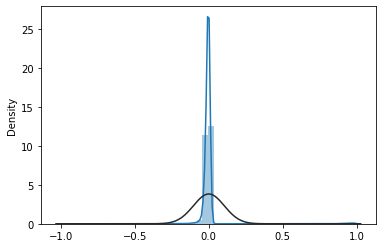

In [315]:
sns.distplot(model.resid_generalized, fit=stats.norm) 

Residuals are not normally distributed

#### Multicollinearity

In [316]:
vifs = np.array([vif(model.model.exog, i) for i in range(model.model.exog.shape[1])])

vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
0,1.004671,visitNumber
3,1.011386,trafficSource.adwordsClickInfo.adNetworkType
7,1.045309,device.operatingSystem_Other
1,1.157706,totals.hits
2,1.164777,totals.bounces
4,1.185248,device.operatingSystem_Chrome OS
5,1.237670,device.operatingSystem_Linux
11,1.581427,weekday_Saturday
12,1.589703,weekday_Sunday
9,1.652762,device.operatingSystem_iOS


Multicollinearity problem is solved, however model appears to be worse than the previous model

## Conclusion

The result logistic model appears to be statistically signficant and describes 40% variance of the variable IsPurchasePerformed. However, the model poorly predicts cases when the purchase actually happens: quantity of FN is greater than quantity of TN. The obtained model has residuals that are distributed not normally, which decreases the quality of the model. In addition, the source model has a problem of multicollinearity, while a try to solve it led to a decrease of correctly identified purchases on visits. All in all, the result model can be used to examine rough 'trends', but all the actual propositions should be stated carefully and should base on other data as well - for instance, on the data from the previous analyses. The logistic model only showed that an increase in totals.hits leads to an increase in a chance to make a purchase. The same trend was found between total.hits and the amount spend on the website. The descriptive analysis proves that there indeed can be such a relation; thus, we can indeed say that an increase in total.hits leads to an increase in a chance to perform a purchase.

# Answers to research questions

### What are the key factors that significantly influence the chance to perform a purchase?

The only factor that indeed has a significant influence on the chance to perform a purchase is total.hits: one hit increase in totals.hits increases the odds to make a purchase by 6%. According to the binary logistic regression analysis, it is the only key factor, but there are also some categorical factors that partially influence the chance to perform a purchase. Such factors include device.operatingSystem, geoNetwork.continent and weekday:
 - For visits from social channels the odds to perform a purchase are 98% lower than for visits from non-detected channels (from group 'other')
 - For visits from Chrome OS the odds to perform a purchase are 5 times higher than for visits from Androids.
 - For visits from Mac the odds to perform a purchase are 6.5 times higher than for visits from Androids.
 - For visits made from Asia the odds to perform a purchase are 97% lower than for visits from a the non-set continent.
 - For visits made from Europe the odds to perform a purchase are 99% lower than for visits from a the non-set continent.
 - For visits made on Saturdays the odds to perform a purchase are 35% lower than for visits on Fridays.
 - For visits made on Tuesdays the odds to perform a purchase are 25% lower than for visits of Fridays.

The logistic regression model describes only 40% variation of the chance to perform a purchase, so probably a better model can be constructed that can describe the variation better. Such a model can also find some other factors that influence the choice to perform a purchase. According to the descriptive analysis, such factors may include:
- channelGrouping (referral channels tend to have a greater chance for a purchase)
- visitNumber (low amount of visits -> greater chance for a purchase)
- device.browser (Chrome outperforms all browsers in terms of a chance to make a purchase)
- device.operatingSystem (visits from Macintosh has a far greater chance for a purchase)
- totals.hits (as logistic regression already captures)
- totals.bounces (sales are made only if there is no cancellation, but regression probably cannot capture it since there are no rows with purchases and a faced cancellation)

Hopefully, the cluster analysis has been performed and it has detected a group of visits at which a purchase is performed. This group can be characterized as follows:

Cluster 'Money generators', with average transaction revenue equals to 113673900, is characterized by below average visit number (3.1) and high number of total hits (39.7). The website is mainly accessed through Referral links. Main device category is desktop, continent is Americas and there are no clicks on ads. Most often, a browser is Chrome, an OS is Macintosh. No cancellation is faced. The visit is often performed on Fridays.

Such a cluster characterizes an average visit into the GMS that provides a purchase. This information can be exploited to make some managerial decisions to increase sales. Such decisions may be from the marketing and from the development sides. From my perspective, advices may be the following:
- Invest into marketing program to increase accessing the website through referral links, since they are the main money generators.
- Pay attention to develop a usability-friendly interface for the desktop, perform additional QA-sessions to increase overall quality of the desktop version of the website to make performing purchases comfortable.
- Investigate the sources of cancellations of the website. If a cancellation is occurred, no sale is performed; thus, such cancellations has to be avoided if it is possible
- Make the main focus of the interface on the americans, since almost all of the sales are performed from this region.
- Lastly, examine groups of visits that always do not provide any purchase, determine the reasons for such fact - maybe some actions can be performed to inspire people perform purchases

### What is the influence of visit parameters on the amount spent on purchases?

According to the linear regression analysis performed, the only 2 factors that influence the amount spent on purchases are visitNumber and totals.hits:
- an increase in visitNumber by one, on average, leads to an increase of the revenue by 1.21%.
- an increase in totals.hits by one, on average, leads to an increase of the revenue by 0.79%.

All other variables appear to be not statistically signficant. However, the actual regression model desribes only 17% variance of the transaction revenue, meaning that the model is not very good, and, potentially, a better model can be constructed. According to the descriptive analysis performed, the following variables may also have an influence on the amount spent on the website:
- channelGrouping (referrals provide more cash, on average)
- device.browser (browser that generates cash is mainly Chrome)
- device.deviceCategory (purchases with high amount of cash are usually done on desktops)
- device.operatingSystem (Macintosh provide more cahs, on average)

Unfortunately, the descriptive analysis cannot be precise enough since it is difficult to get a measure to correctly compare different groups. Currently, the sum is used since it shows the actual money that the whole group provided to the GMS, but to proper measure the amount spent, the mean/median can be used, but it won't show a real picture, becase there can be only few sales let's say for 1 million in one group and thousands of sales for 800 thousands in another group. Here the sum would still be a better estimation.

We have performed the cluster analysis that can show us the groups of users divided by the amount spent of the website. Such an analysis could show the actual circumstances under which the most expensive purchases are performed. The results of the cluster analysis are the following:

- Cluster with a very high transaction revenue is characterized by above average visit number (3.6) and quite high total hits. Visits from this cluster do not usually have clicks on ads. Website is accessed using referral links. Browser is Chrome and OS is Mac. Visits from this group are more often on Tuesdays. 

- Cluster with medium transaction revenue is characterized by nearly average visit number (2.5) and sufficiently low total hits. Visits from this cluster more often have clicks on ads. Website is accessed with a Paid Search. A browser is Chrome and OS is Mac. Visits from this group are more often on Wednesday.

- Cluster with lower transaction revenue is characterized by quite a low visit number (1.5) and quite high total hits number. Visits from this cluster more often have clicks on ads. Website is accessed using a Paid Search. A browser is Firefox and OS is Windows. Visits from this group are more often on Fridays and Tuesdays.

Thus, if we want to focus on the visits with high transaction revenue, we have to consider cases when amount of total hits and visit number are quite high, ads are not clicked, website is accessed using referral links, the browser used is Chrome and OS used is Mac.

With this information in mind, the following managerial decisions can be made:
- Invest more in referral searches as they generate more cash.
- Make the website interface convenient for Macinstosh users.
- Evaluate effectivess of ads on the website - maybe they can be removed and cash obtained could be even increased.
- Make website updates strictly not on Tuesdays - preferably, on weekends, when the quantity of users is lower and purchases are lower as well.
- Estimate effectiveness of spending cash for Paid Search and compare it with investing in referrals: maybe some cash can be reallocated to generate more profits.

### What are the groups of visits in the GMS that need special attention?

Results of cluster analysis can be used to indicate the groups of users that require special attention. From my perspective, the following groups have to be thoroughly studied and a signficant attention must be paid for them to increase profits from the GMS (so as to increase a chance of a purchase and the amount of the purchase):

1. 'Indecisives'. A group of visits characterized by very high visit number, below average total hits and zero revenue. The channel is mainly organic search, a browser is Chrome and OS is Windows. No cancellation is faced. Visits are most often done on Thursdays. Due to high amount of previous visits, the users are really interested in production of GMS but still not buy anything. Possibly, some advertising can be done to force them make a purchase. However, a further analysis is needed, since such visits may be from cafes and computer clubs, where such an indicator can easily grow due to visits from other users. Nevertheless, management needs to pay significant attention to this group of visits.

2. 'Newcomers with cancellations' A group of visits characterized by the lowest visit number, lowest total hits and zero revenue. The channel is mainly organic search, a browser is Chrome and OS is windows. Cancellation is faced. Visits are most often done on Tuesdays. It is important to study the problem why a cancellation occurs since all the visits with a cancellation, obviously, do not generate any cash. In addition, some attractive features may be developed to keep the user on the website and encourage him/her to make a purchase.

3. 'Main Money Generators'. A group of visits characterized by above average visit number (3.6), quite high total hits and the highest revenue. The cahnnel is mainly referral, a browser is Chrome, OS is Mac. No cancellation is faced. No clicks on ads. Visits are more often done on Tuesdays. This group of visits generate the main amount of cash and, thus, must be investigated properly. Enough attention should be paid to this group of visits not to lose them in future. So the main aim here is to maintain or increase frequency of such visits.

4. 'Newcomers with small purchases'. A group of visits characterized by quite a low visit number (1.5), quite high total hits number and lower transaction revenue. Visits from this cluster more often have clicks on ads. Website is accessed using a Paid Search. A browser is Firefox and OS is Windows. Visits from this group are more often on Fridays and Tuesdays. What the website needs is to increase the cash that these users generate. Potentially, the website can propose other products to buy or perform some promos to encourage people to spend more money.

Paying attention to the described groups can bring even more money to the website holders.

# Interesting data gathered that is not straightforwardly related to the research questions

1. Total.hits and VisitNumber both correlate with transaction revenue in nearly the same manner: increase in any of them increases the revenue. On the large datasets (we have taken only 0.1 of the whole) these columns can be combined into one using factor analysis.

2. If cancellation is faced, there is no chance for a transaction. It is very important to understand sources of such bounces to prevent them in future if it is possible.

3. People use desktops mainly in working days, whereas tablets and smartphones are used nearly equally throughout the week. This information can be used for choosing appropriate time and date for updating website version for desktops. A futher analysis can also be conducted to estimate circumstances in which people use desktops in working days: for instance, it may be in afternoons at work or in evenings at home.

4. Some categorical variables strongly correlate with each other and potentially can also be groupped. Such correlations exist between browser, OS and device type, for instance. Interestingly, there is a correlation between channelGrouping and click on ads: clicks on ads only occur in Paid Search. Probably, it is better to ask developers how they measure ad clicks and what is the source of this correlation.

5. Almost all of the sales are done in Americas only (1091 out of 1111, see data below), but the quantity of visits from other continents is quite high. It is needed to understand the reasons why people from other continents do not make purchases: maybe, there are problems with payment systems that allow mainly american payment systems. People from other countries are also interested in production of GMS, so it is needed to understand the reasons for low purchases in these countries. In addition, cancellation in Americas are far less often than in all other continents - maybe it is one of the reasons for absence of sales in other countries.

6. Visits from social channels almost always do not generate any cash. Thus, it appears a question, whether it is profitable to invest in promotions in social networks: maybe, this cash can be reallocated to more profitable channels.

##### Distribution of purchases among countries

In [335]:
df_with_purchases.groupby('geoNetwork.continent')['IsPurchasePerformed'].count()

geoNetwork.continent
(not set)       1
Africa          2
Americas     1091
Asia           12
Europe          2
Oceania         3
Name: IsPurchasePerformed, dtype: int64